In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import arviz as az
import itertools
from itertools import product
from math import comb

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc('axes', prop_cycle=default_cycler)
plt.rc('figure', dpi=300)

In [3]:
np.random.seed(2024)

trials = 4
theta_real = 0.35  # unknown value in a real experiment
data = pz.Binomial(n=1, p=theta_real).rvs(trials)

In [4]:
data

array([0, 1, 0, 0])

The Beta distribution is specified as:

$\theta$ ~ Beta($\alpha = 1, \beta = 1$)

Y ~ Binomial($n = 1, p = \theta$)


In [5]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha = 1., beta = 1.)  # Prior
    y = pm.Bernoulli('y', p = theta, observed = data)  # Likelihood data that can be a Python list, NumPy array, tuple, or pandas DataFrame
    idata = pm.sample(1000)  # idata is an InferenceData object 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


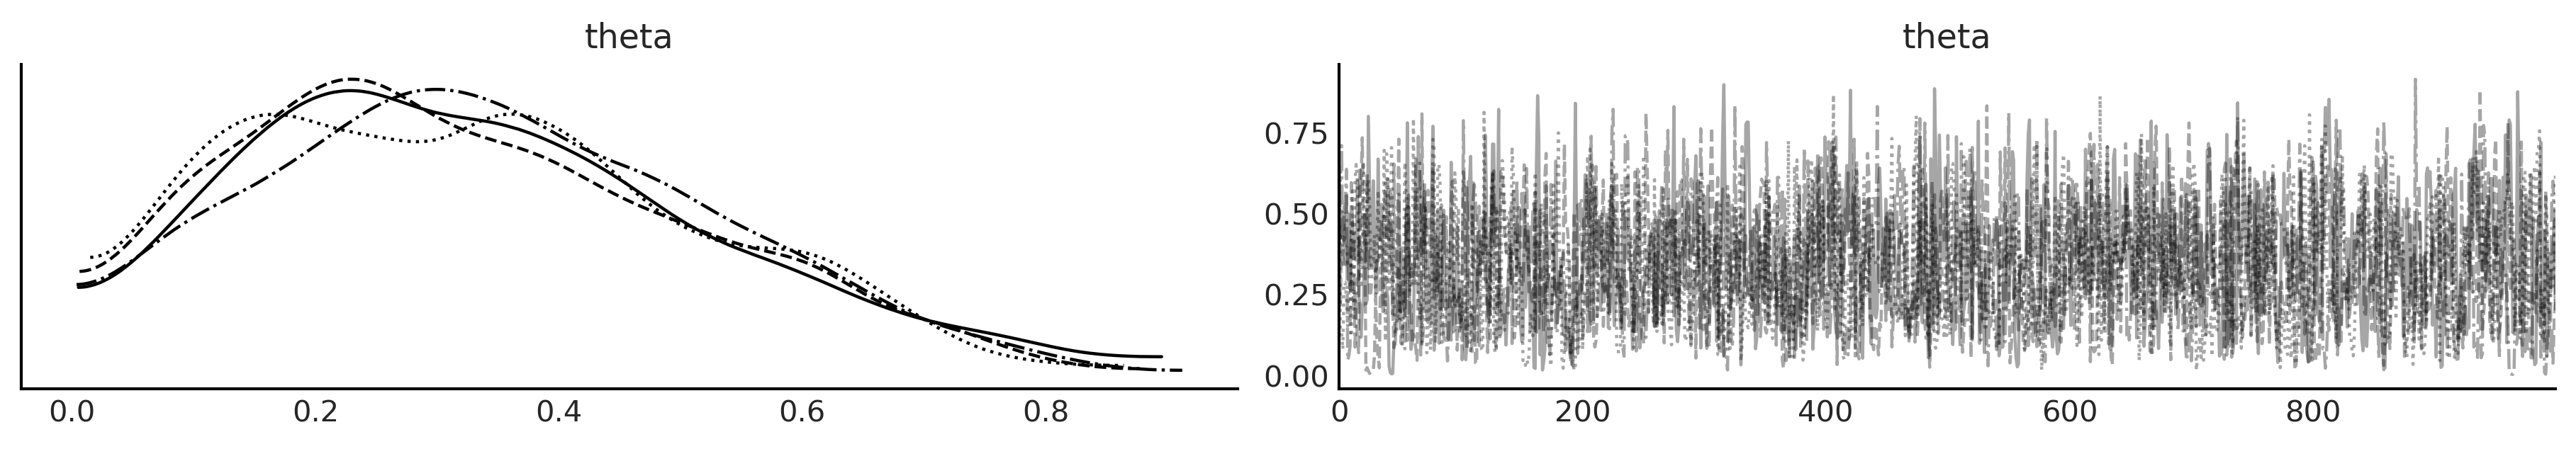

In [6]:
az.plot_trace(idata);

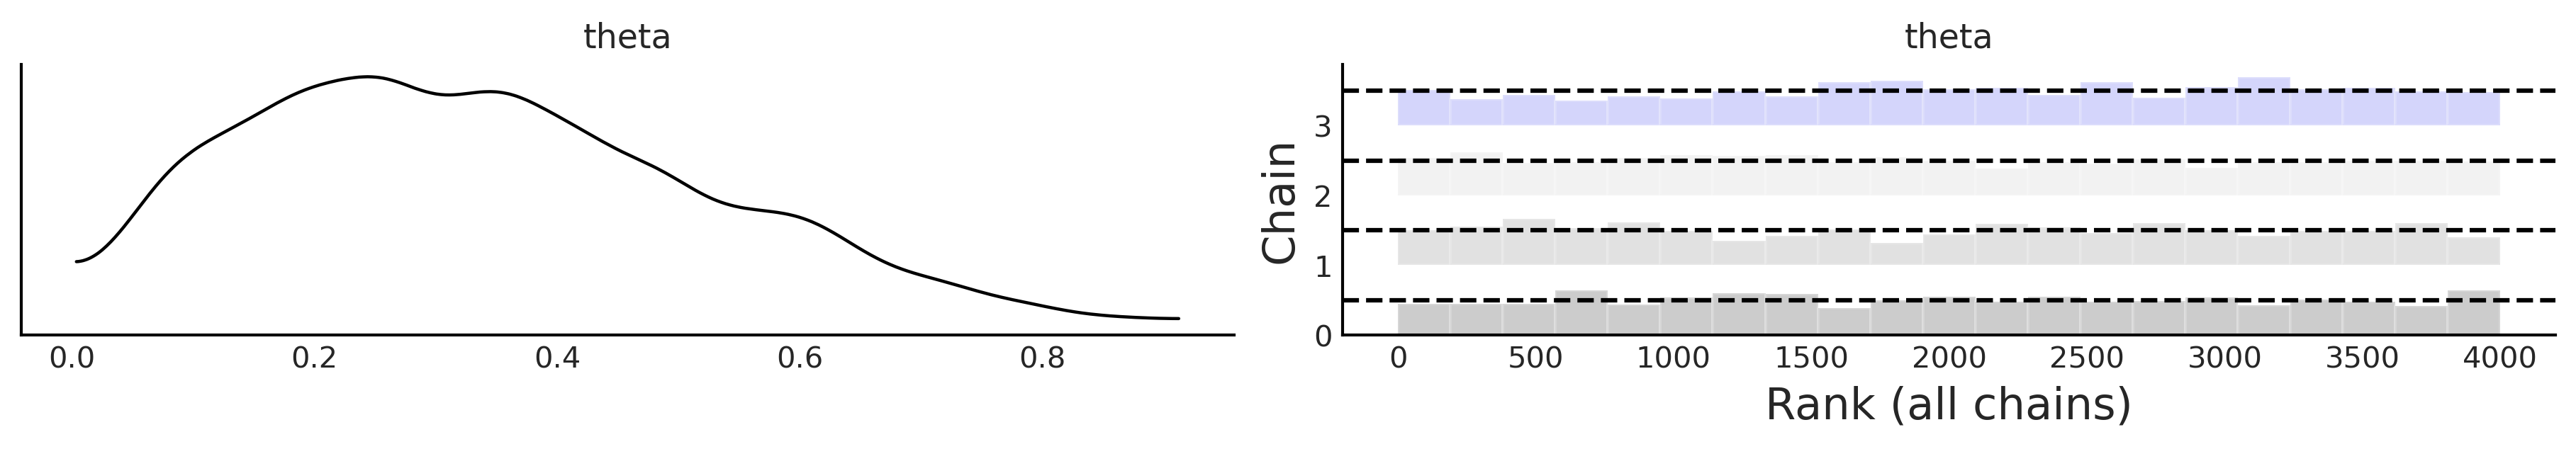

In [7]:
az.plot_trace(idata, kind = "rank_bars", combined=True);

In [8]:
az.summary(idata, kind='stats', hdi_prob=0.94).round(2)

mean    sd  hdi_3%  hdi_97%
theta  0.34  0.18    0.04     0.67

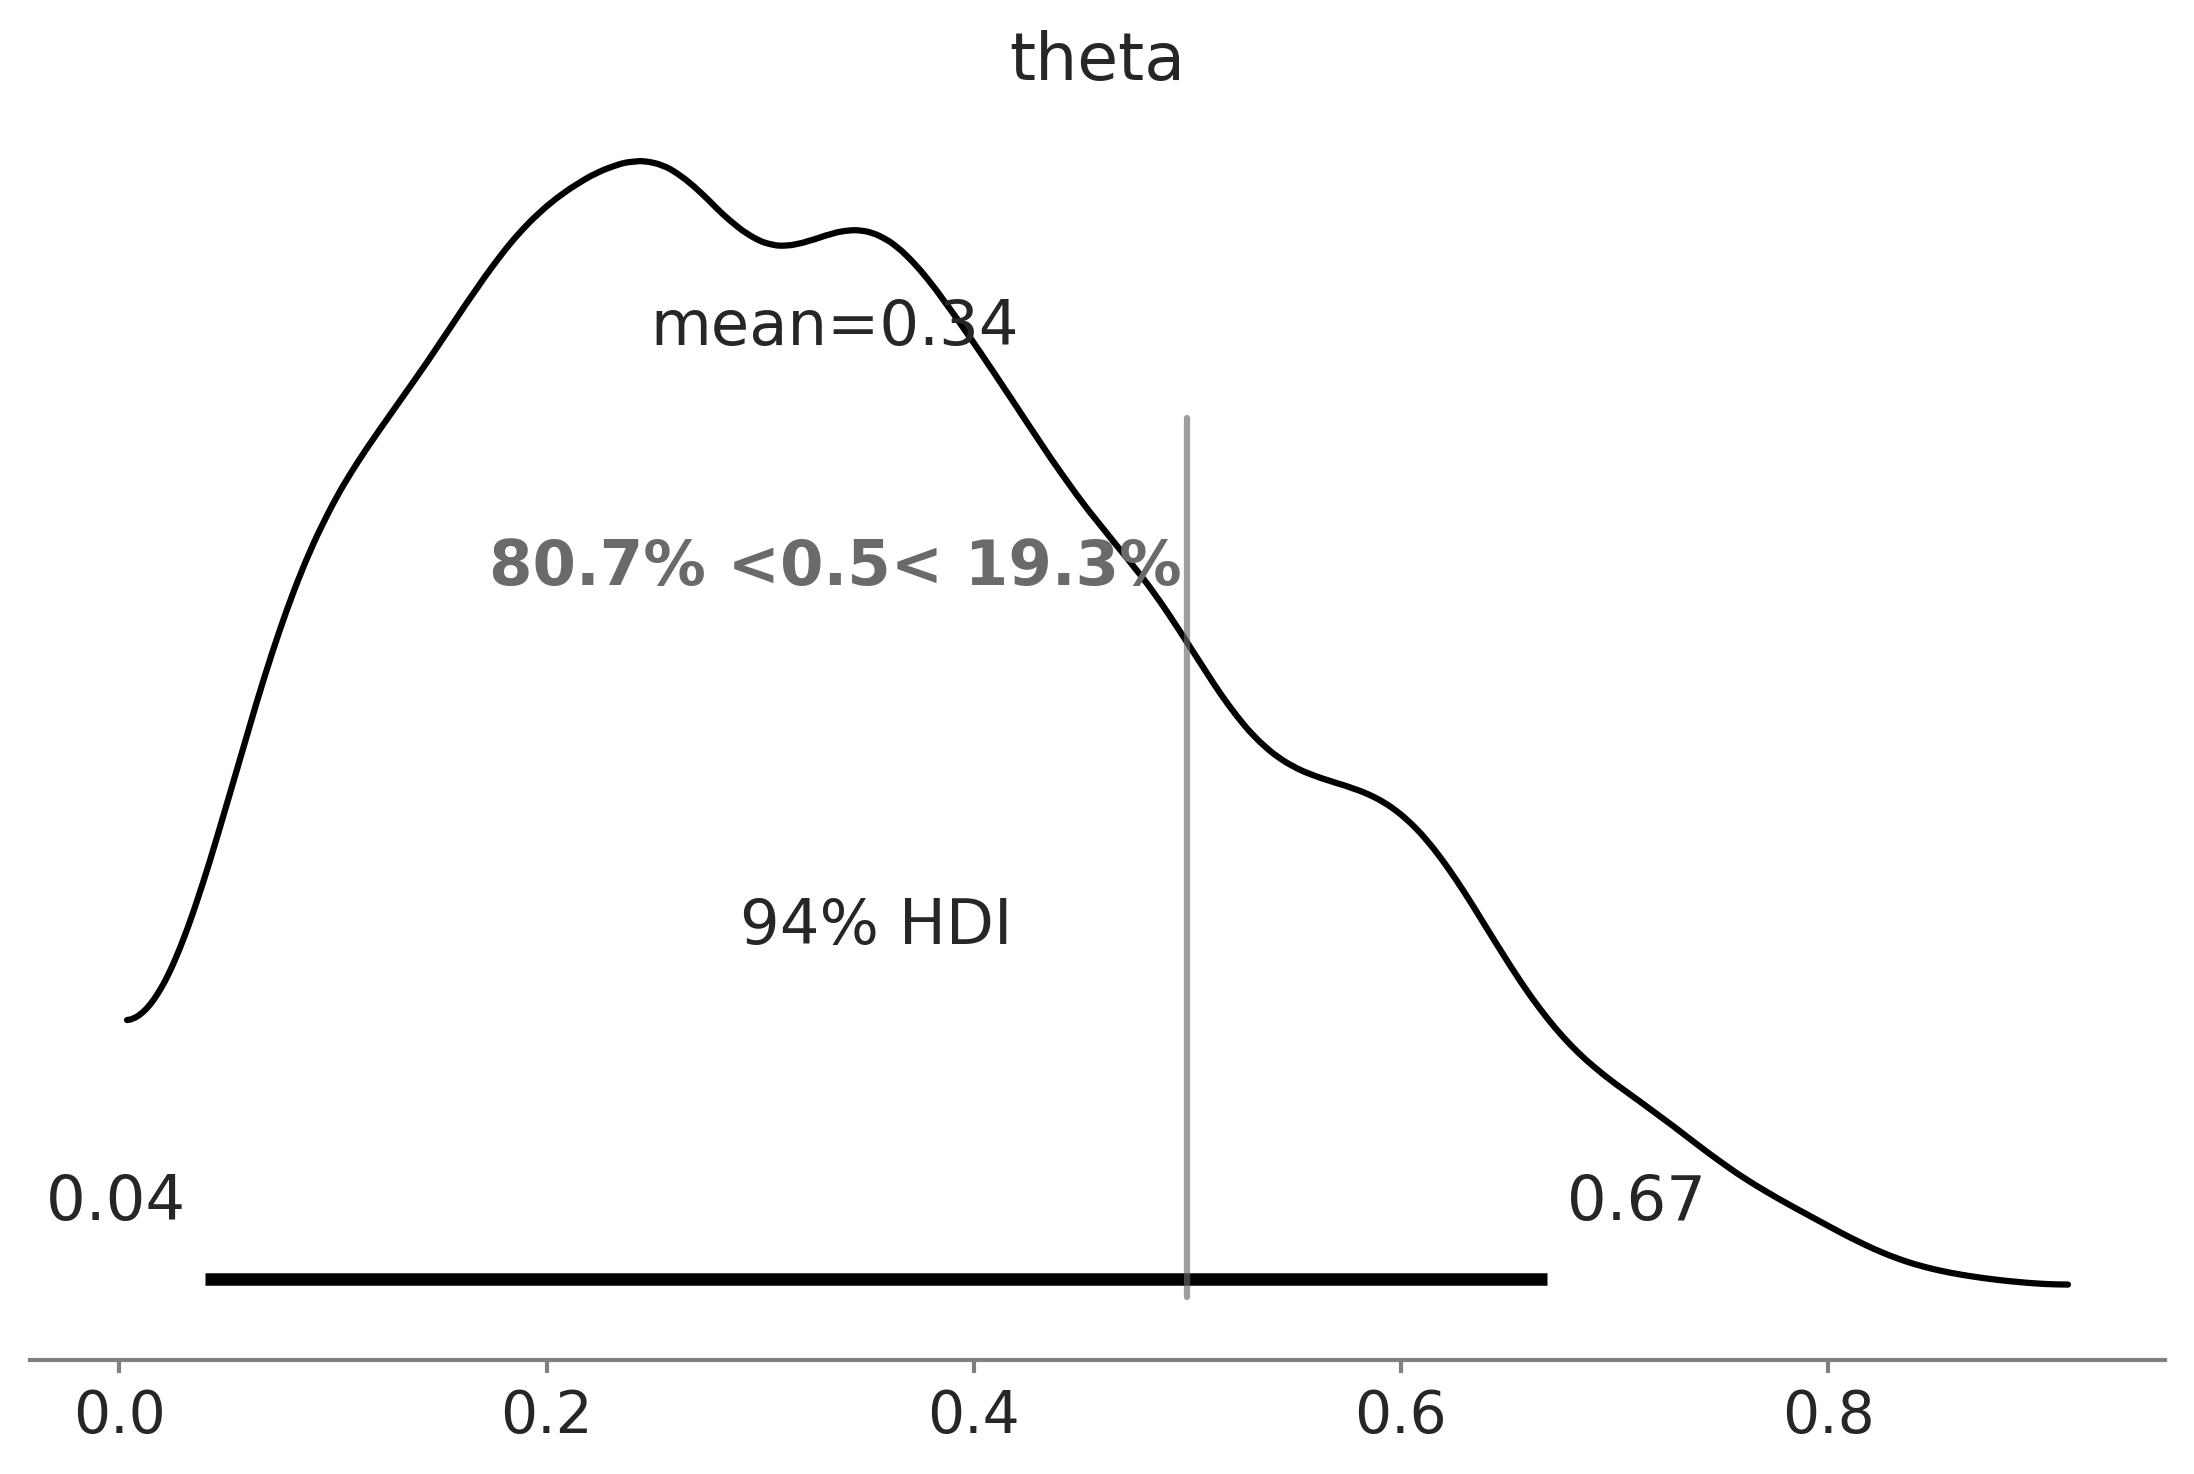

In [9]:
az.plot_posterior(idata, ref_val=.5);

# Bayes Factors using the Savage-Dickey density ratio
Evaluate how much support the posterior provides for a given value by comparing the ratio of the posterior and prior densities at that value.

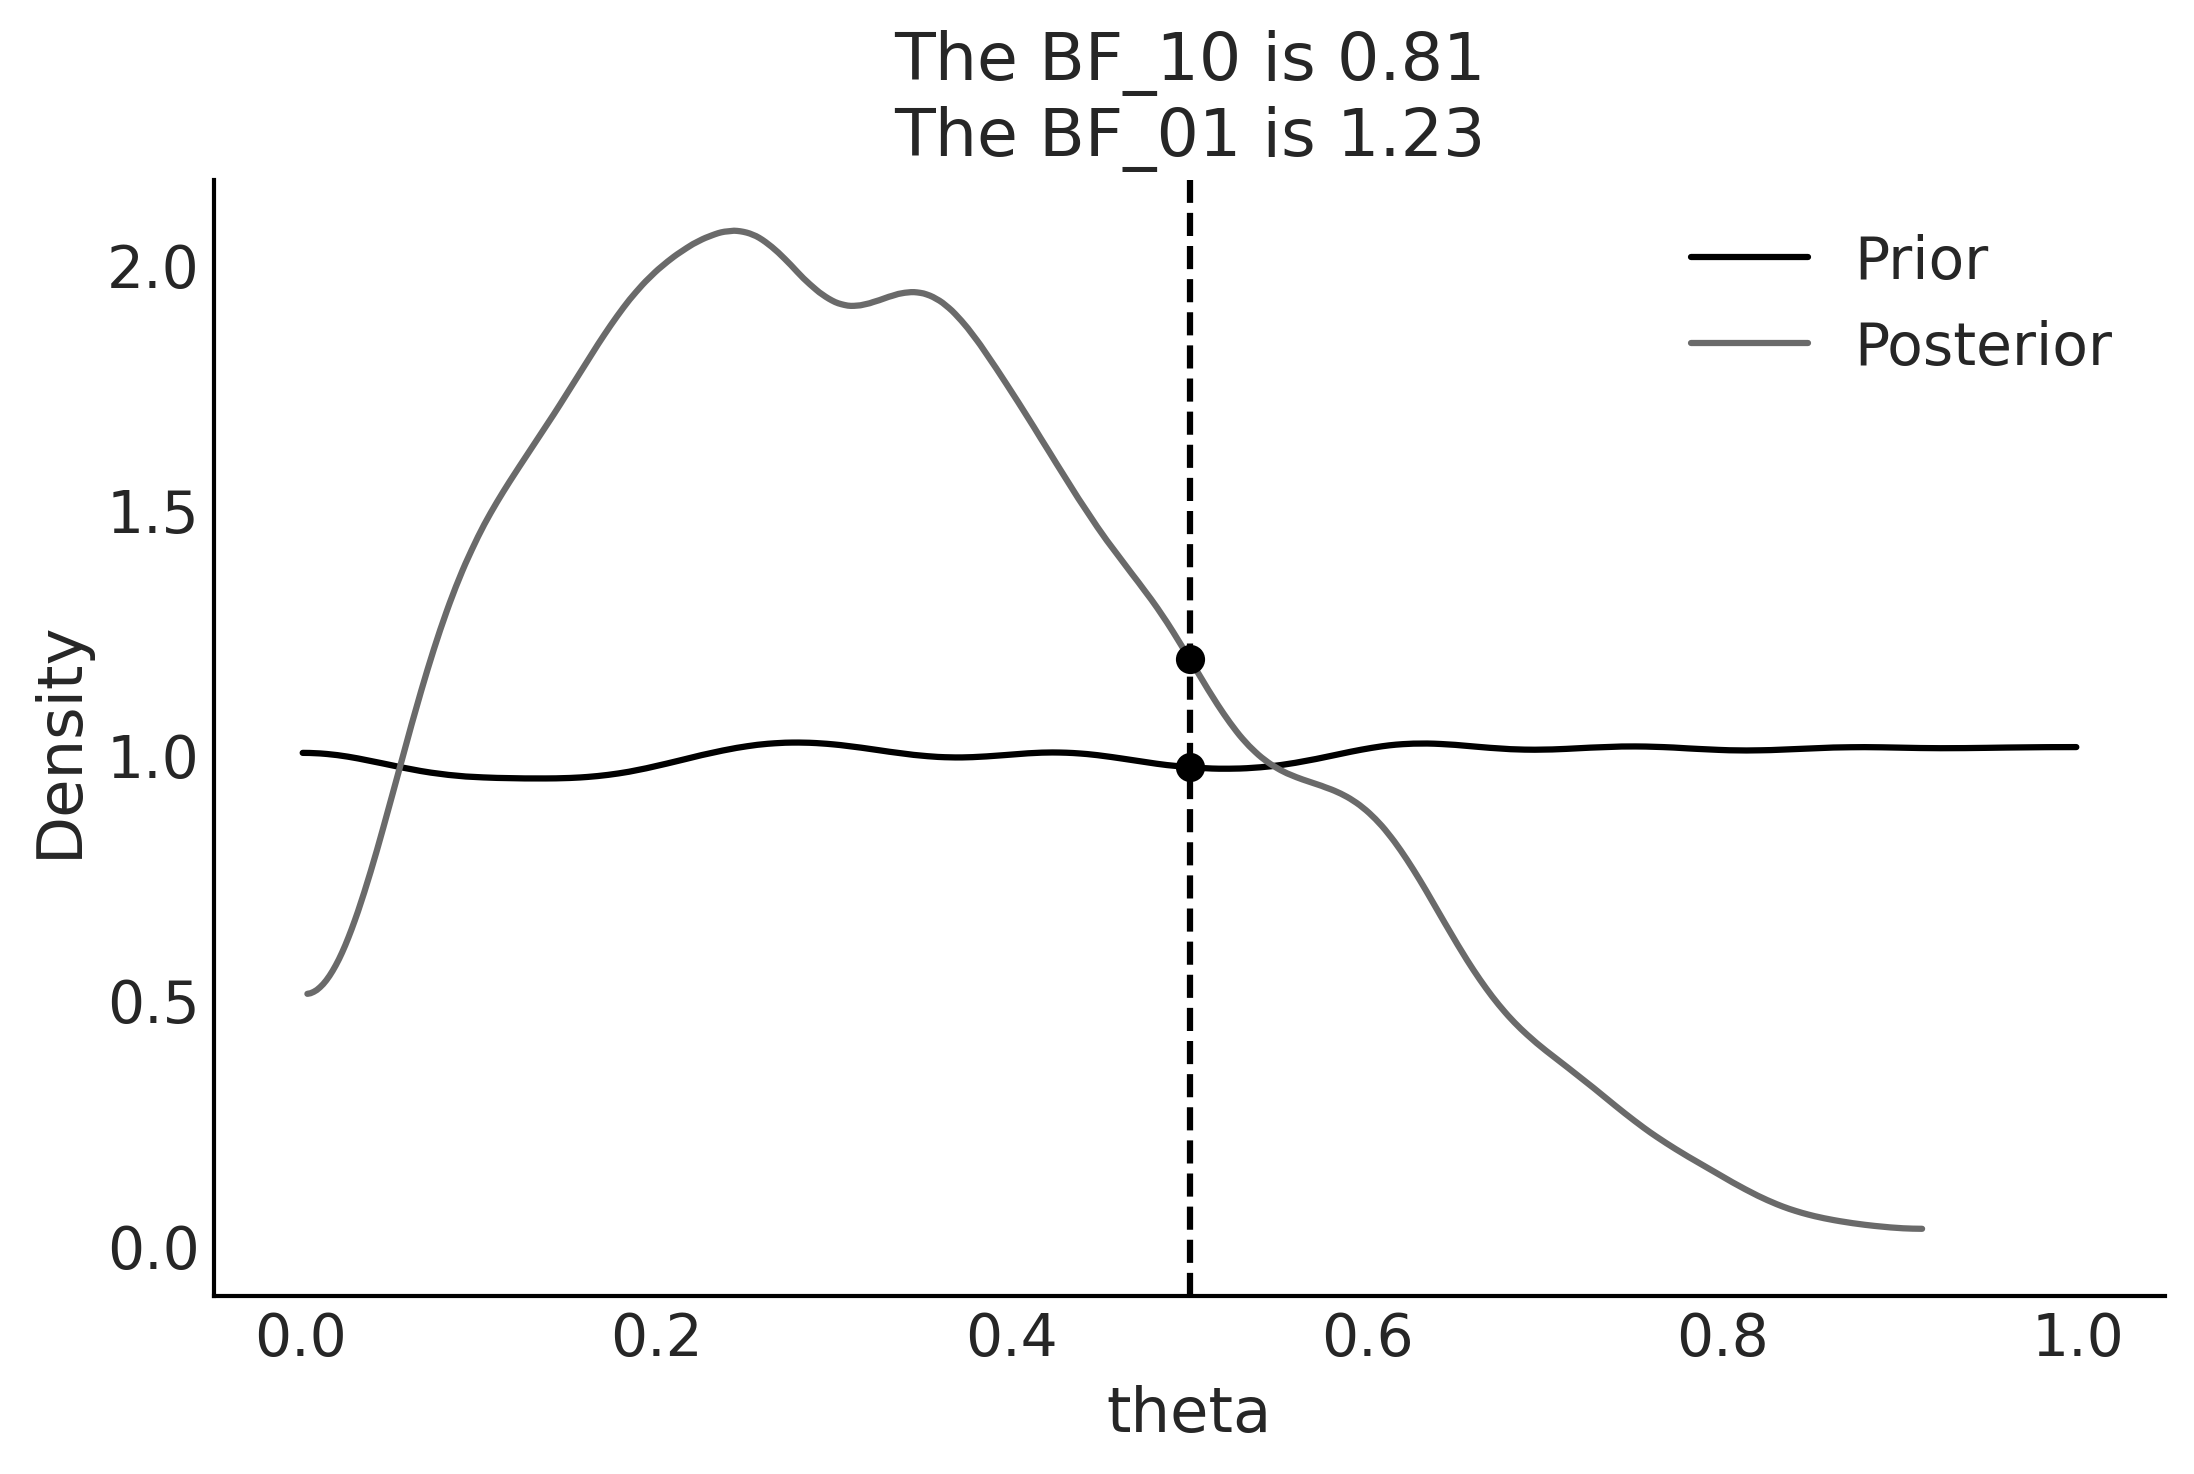

In [10]:
az.plot_bf(idata, var_name='theta', prior=np.random.uniform(0, 1, 10000), ref_val=0.5);

The value of theta = 0.5 is 1.35 times more likely under the posterior distribution than under the prior distribution.

| BF_01     | Interpretation                |
-:-----------:-----------------------------:||
1 to 3.2x|   Not worth more than a mentio  ||3.2 to 10|   Substantial                 |  
| 10 to 100 | Strong                        |
| > 100     | Decisive                      | |

<table>
    <tr>
        <th>BF_01</th>
        <th>Interpretation</th>
    </tr>
    <tr>
        <td>1 to 3.2x</td>
        <td>Not worth more than a mention</td>
    </tr>
    <tr>
        <td>3.2 to 10</td>
        <td>Substantial</td>
    </tr>
    <tr>
        <td>10 to 100</td>
        <td>Strong</td>
    </tr>
    <tr>
        <td>&gt; 100</td>
        <td>Decisive</td>
    </tr>
</table>


# Region of Practical Equivalence

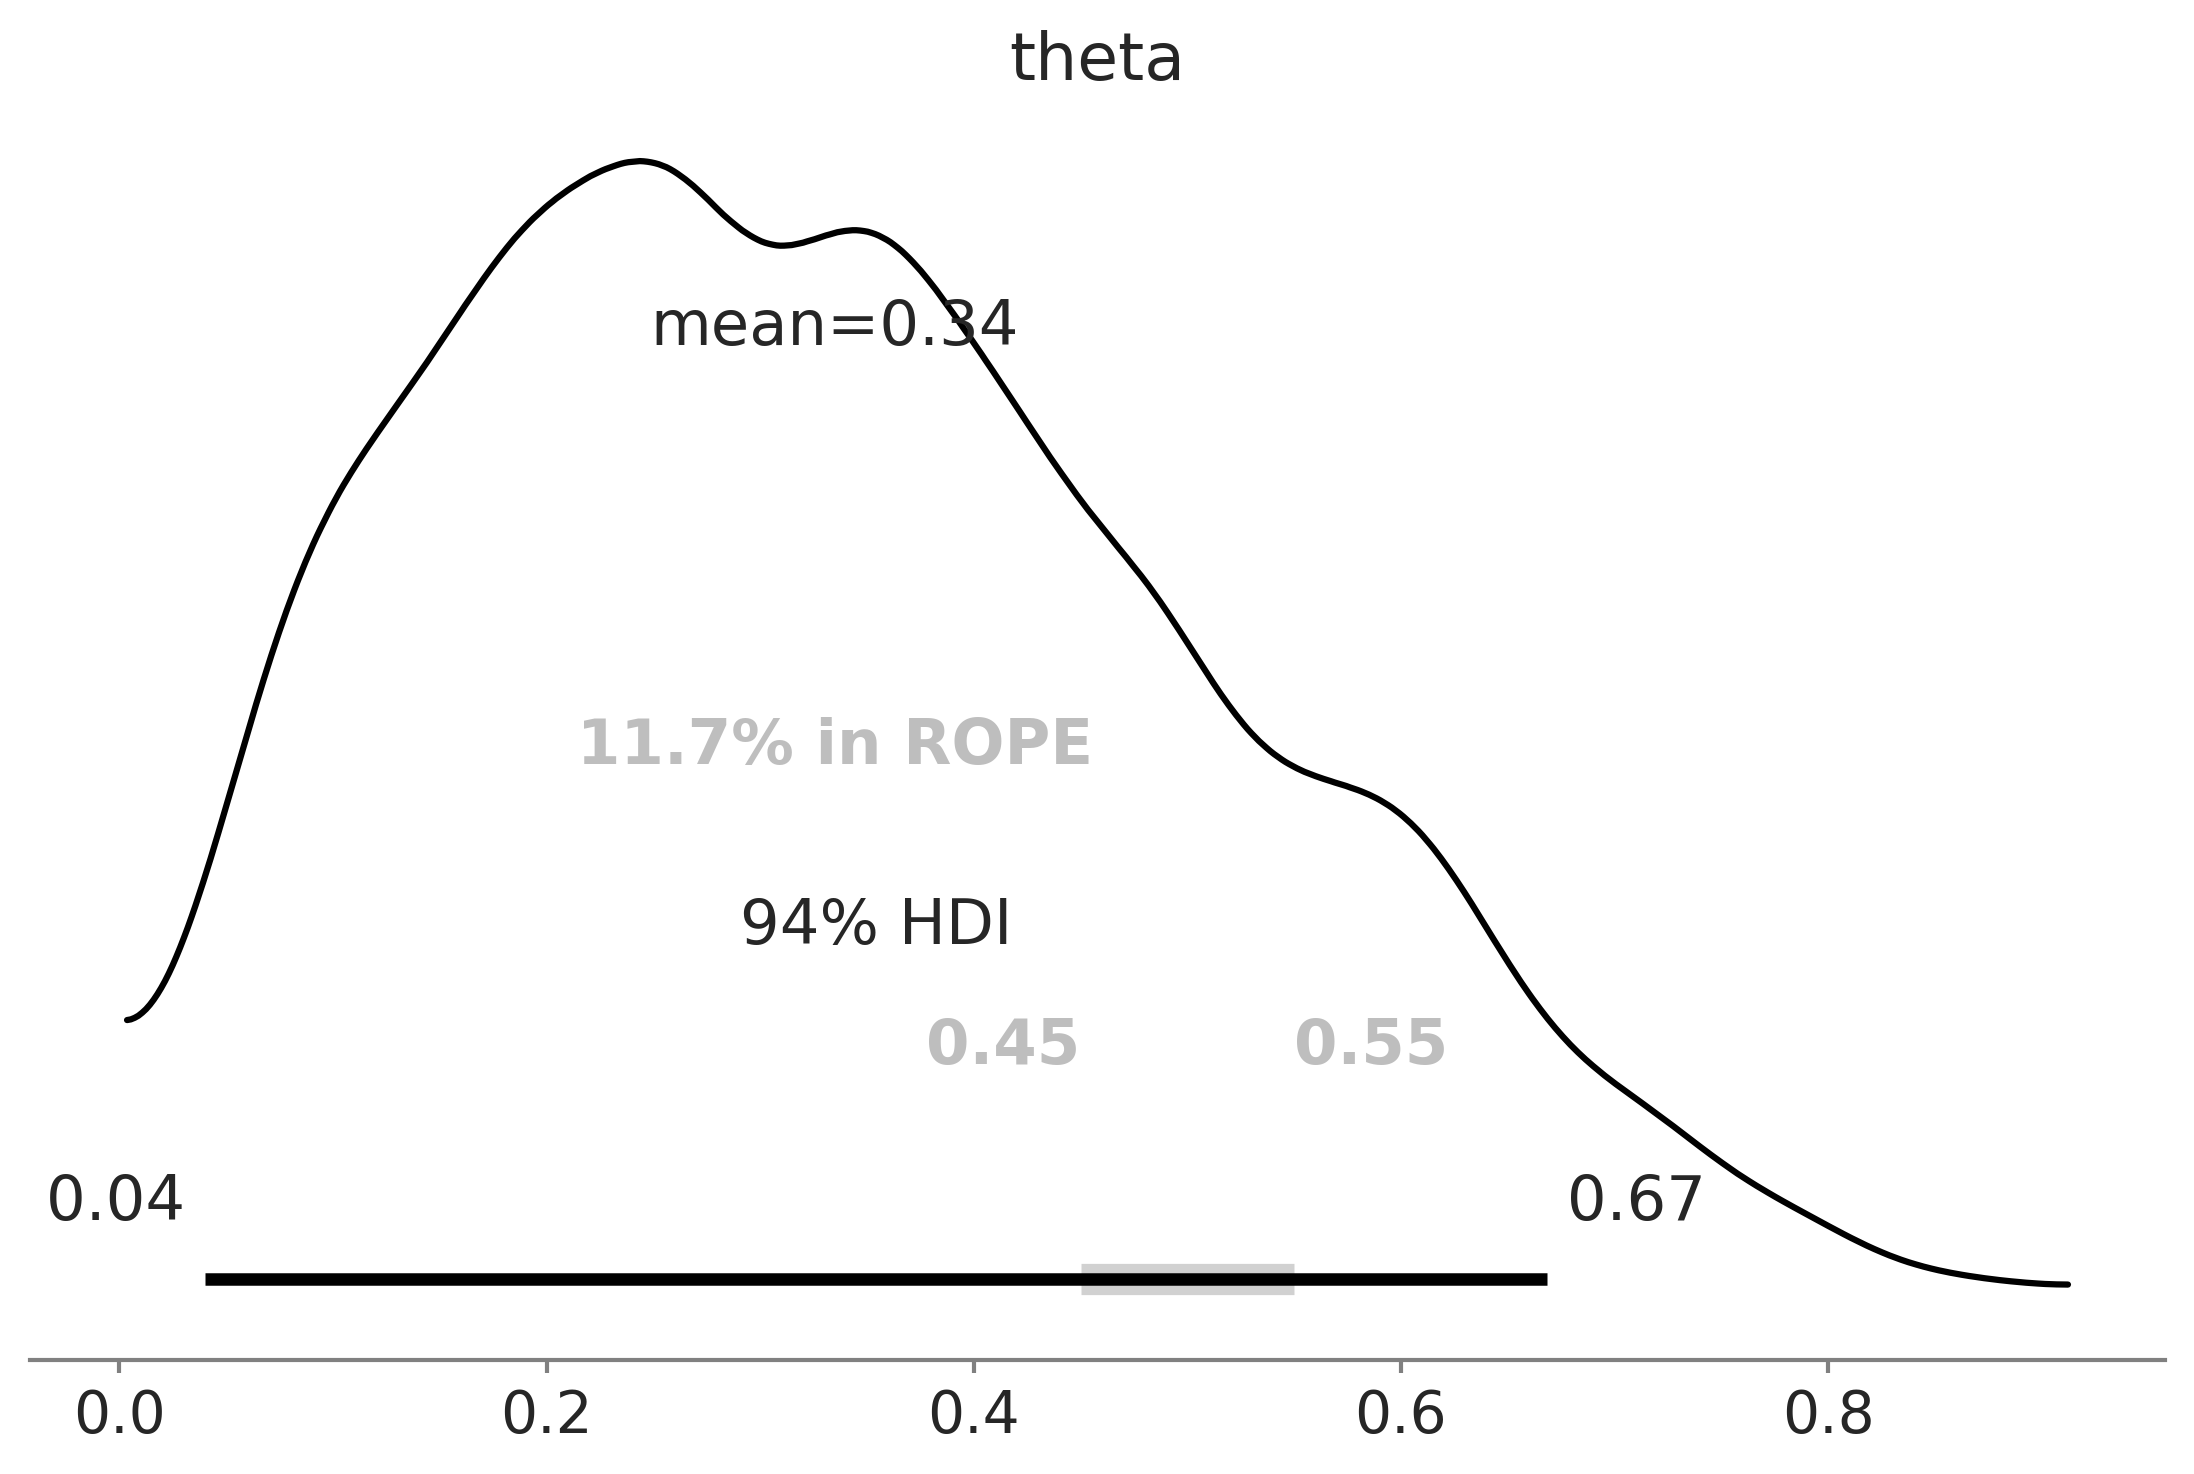

In [11]:
az.plot_posterior(idata, rope=[0.45, 0.55]);

# Loss Functions

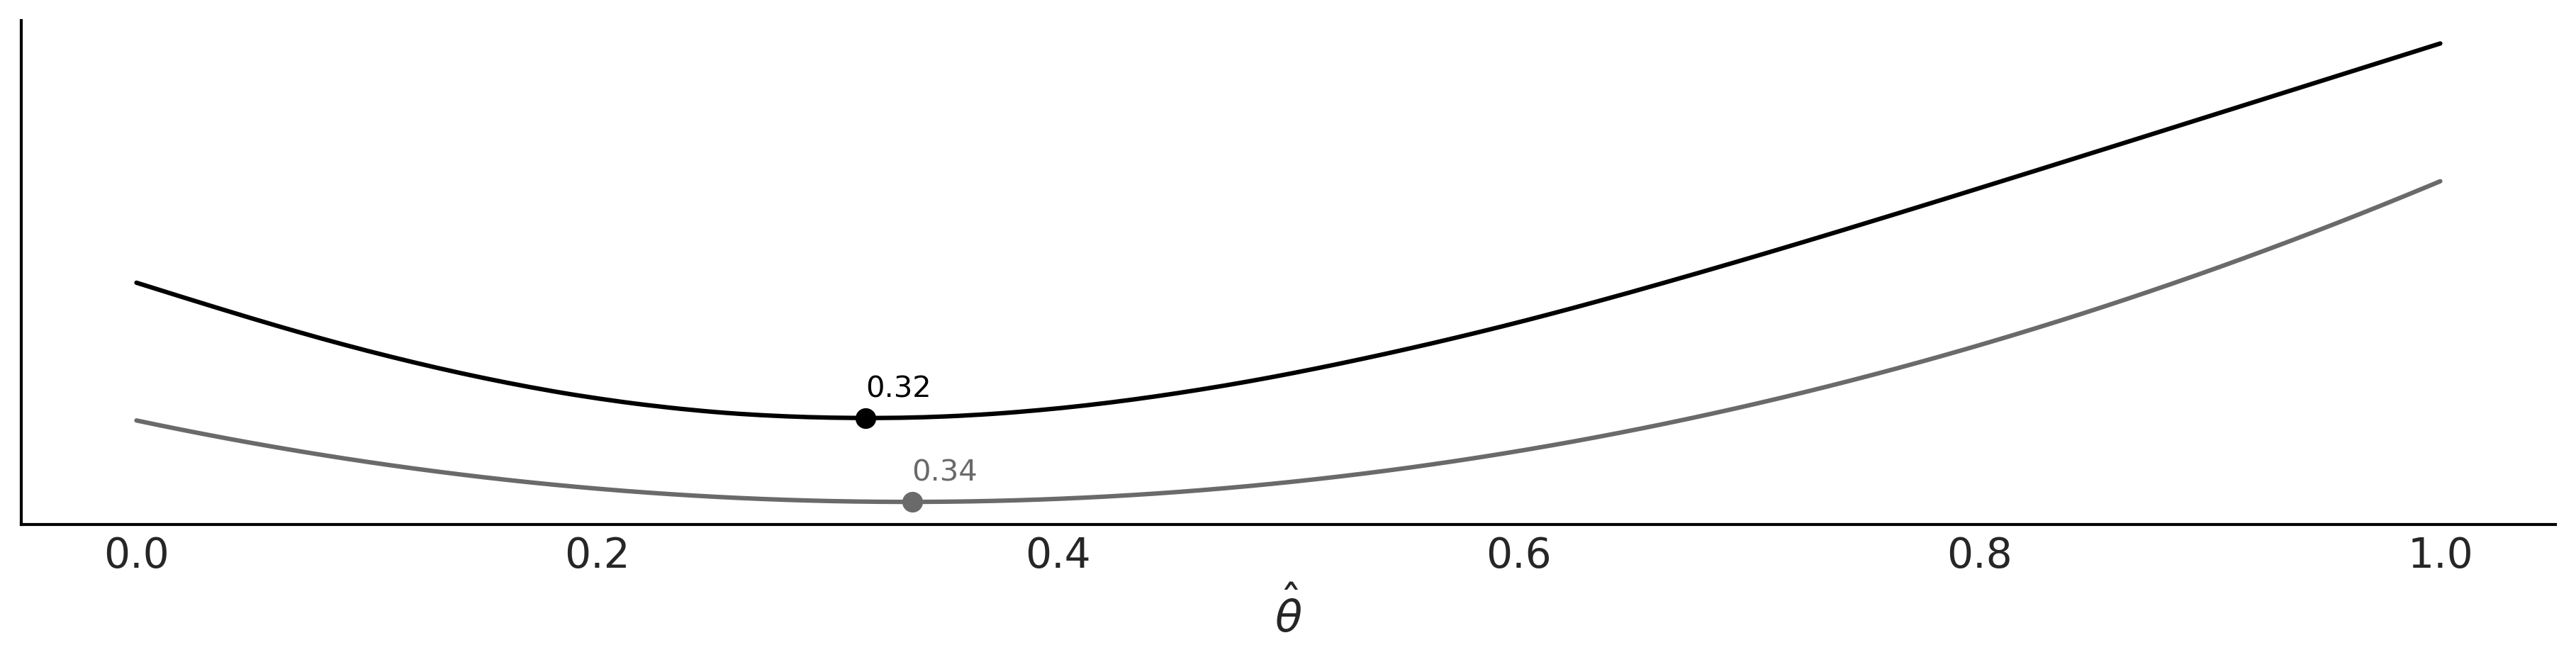

In [12]:
grid = np.linspace(0, 1, 200)
theta_pos = idata.posterior['theta']
lossf_a = [np.mean(abs(i - theta_pos)) for i in grid]
lossf_b = [np.mean((i - theta_pos)**2) for i in grid]
_, ax = plt.subplots(figsize=(12, 3))
for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    ax.plot(grid, lossf, c)
    ax.plot(grid[mini], lossf[mini], 'o', color=c)
    ax.annotate('{:.2f}'.format(grid[mini]),
    (grid[mini], lossf[mini] + 0.03), color=c)
    ax.set_yticks([])
    ax.set_xlabel(r'$\hat \theta$')

plt.savefig("../fig/idata_loss.png")

In [13]:
lossf_a[0:1]

[<xarray.DataArray 'theta' ()>
 array(0.33506718)]

In [14]:
np.argmin(lossf_a[0:200])

63

In [15]:
# The absolute loss is equal to the median of the posterior
np.median(theta_pos)

0.3190692636968789

In [16]:
grid[np.argmin(lossf_a[0:200])]

0.3165829145728643

In [17]:
# The quadratic loss is equal to the mean of the posterior
np.mean(theta_pos)

<xarray.DataArray 'theta' ()>
array(0.33506718)

In [18]:
grid[np.argmin(lossf_b[0:200])]

0.33668341708542715

In [19]:
# Custom weird loss function
lossf = []
for i in grid:
    if i < 0.5:
        f = 1/np.median(theta_pos / np.abs(i**2 - theta_pos))
    else:
        f = np.mean((i - theta_pos)**2 + np.exp(-i)) - 0.25
    lossf.append(f)

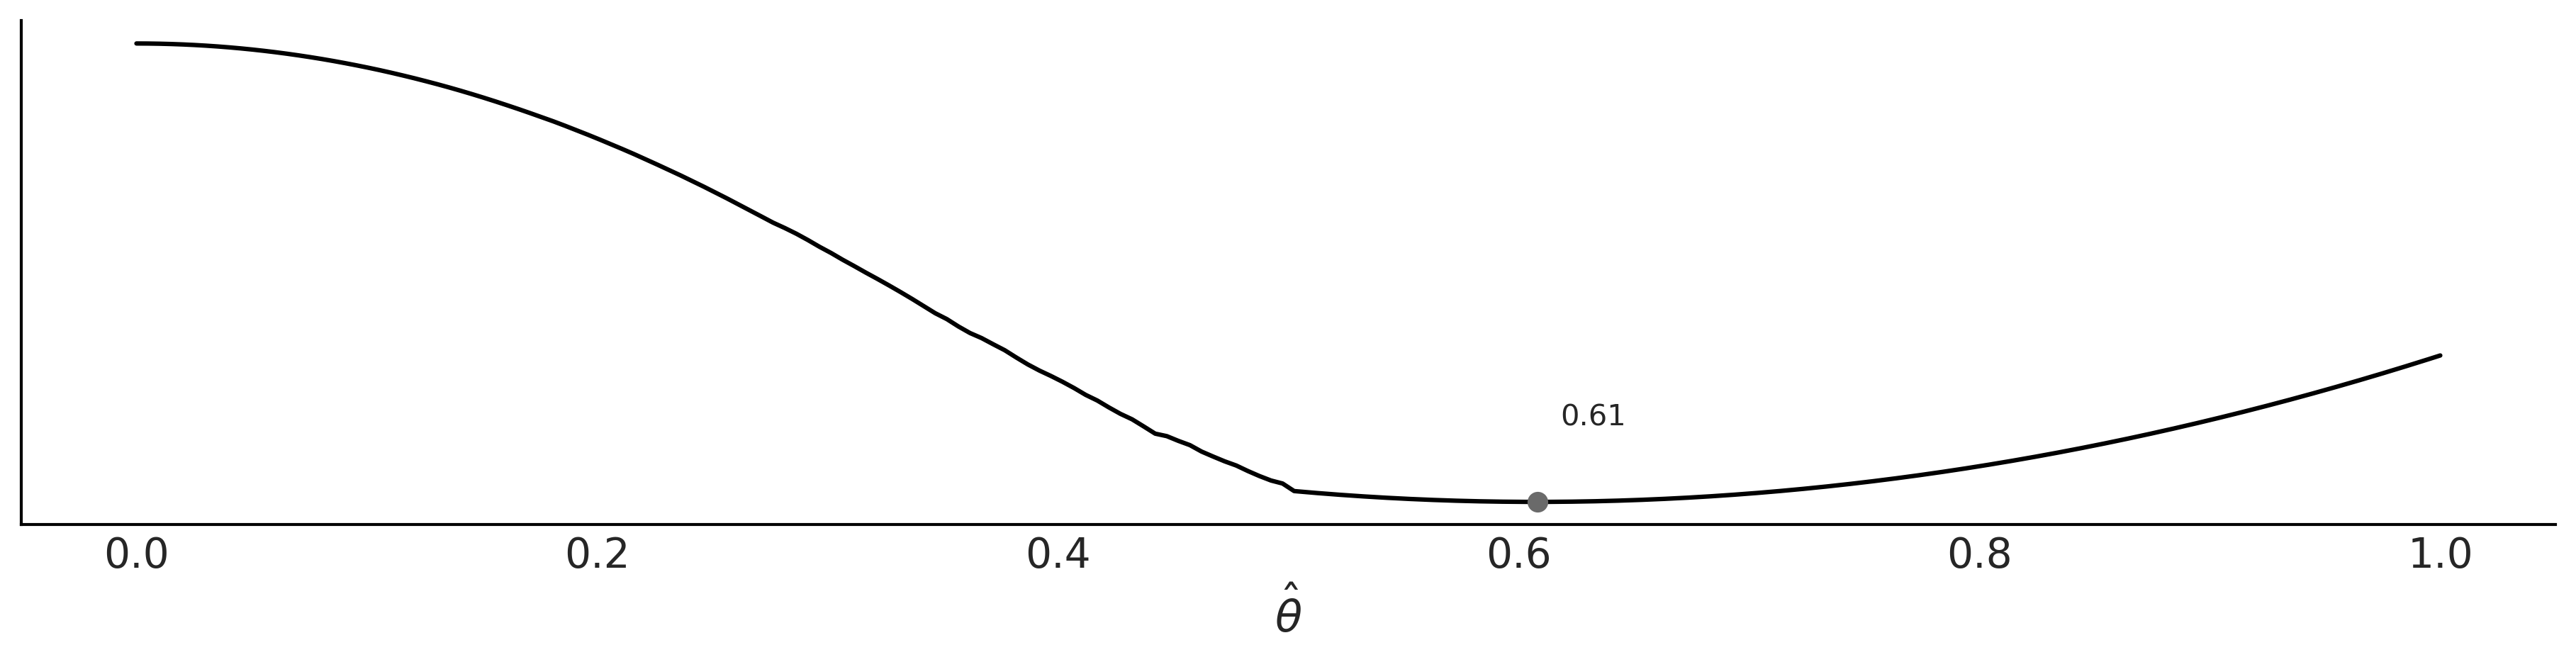

In [20]:
mini = np.argmin(lossf)
_, ax = plt.subplots(figsize=(12, 3))
ax.plot(grid, lossf)
ax.plot(grid[mini], lossf[mini], 'o')
ax.annotate('{:.2f}'.format(grid[mini]),
(grid[mini] + 0.01, lossf[mini] + 0.1))
ax.set_yticks([])
ax.set_xlabel(r'$\hat \theta$')
plt.savefig("../fig/idata_loss2.png")

# Gaussian model in PyMC

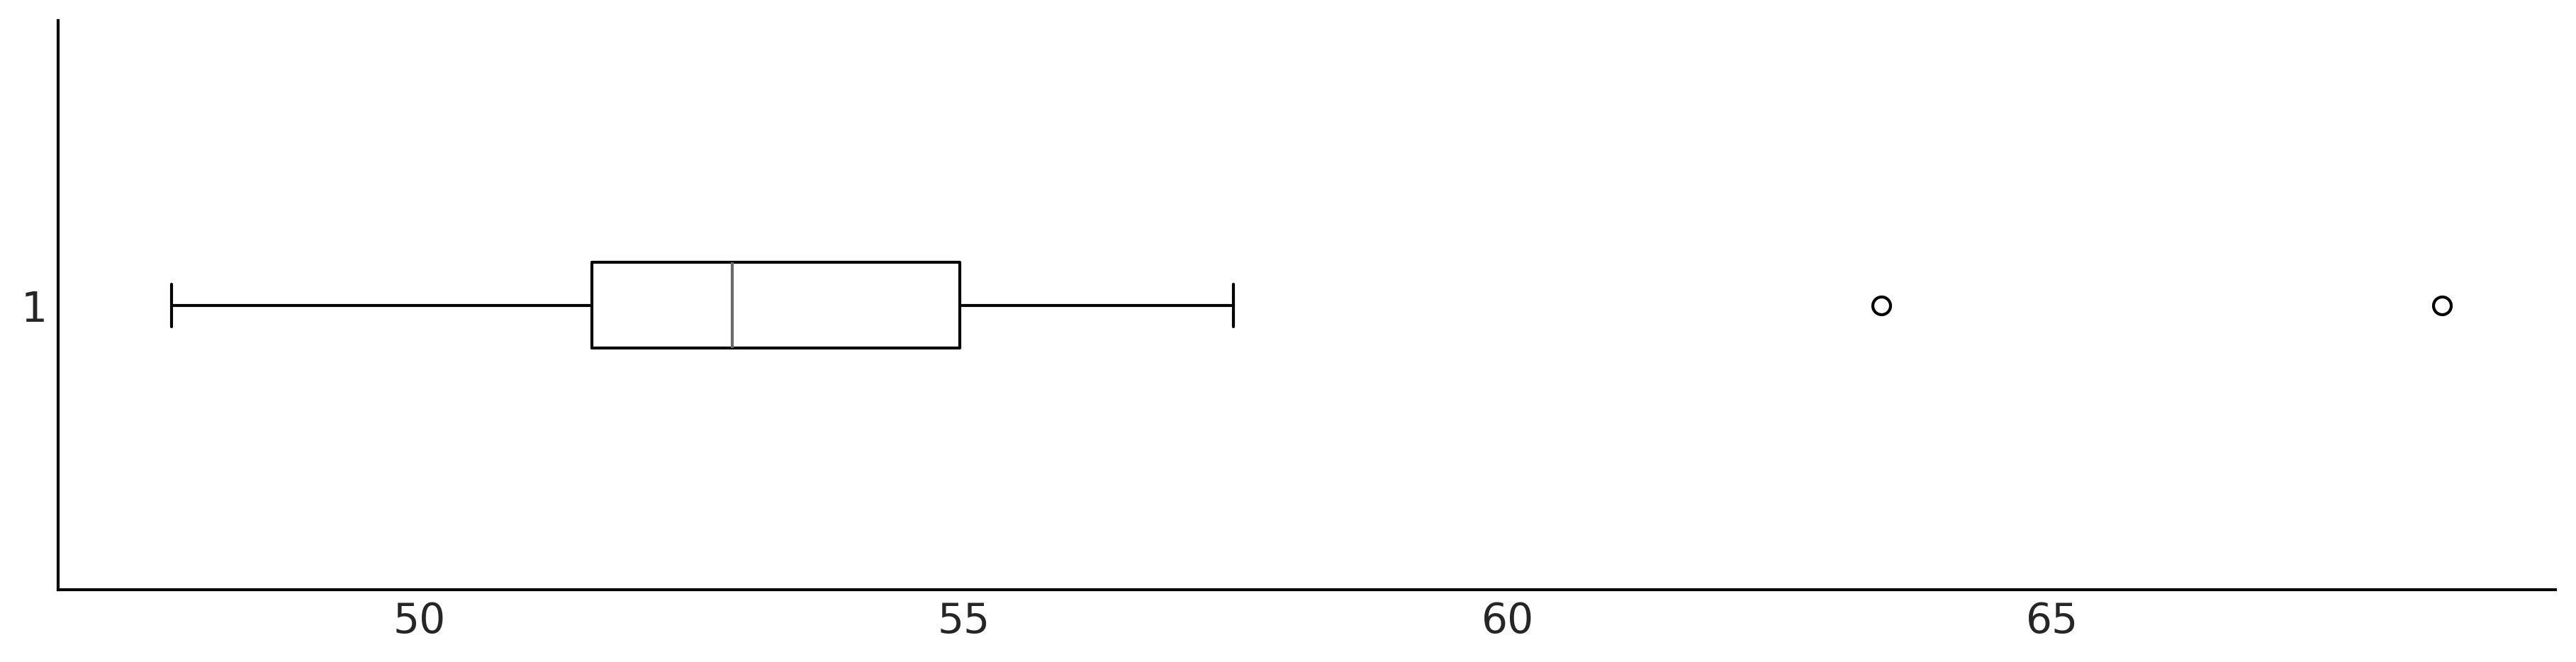

In [21]:
data = np.loadtxt("../code/data/chemical_shifts.csv")
_, ax = plt.subplots(figsize=(12, 3))
ax.boxplot(data, vert=False)
plt.savefig("../fig/boxplot.png")

In [22]:
with pm.Model() as model_g:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sigma=5)
    Y = pm.Normal('Y', mu=mu, sigma=sigma, observed=data)
    idata_g = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


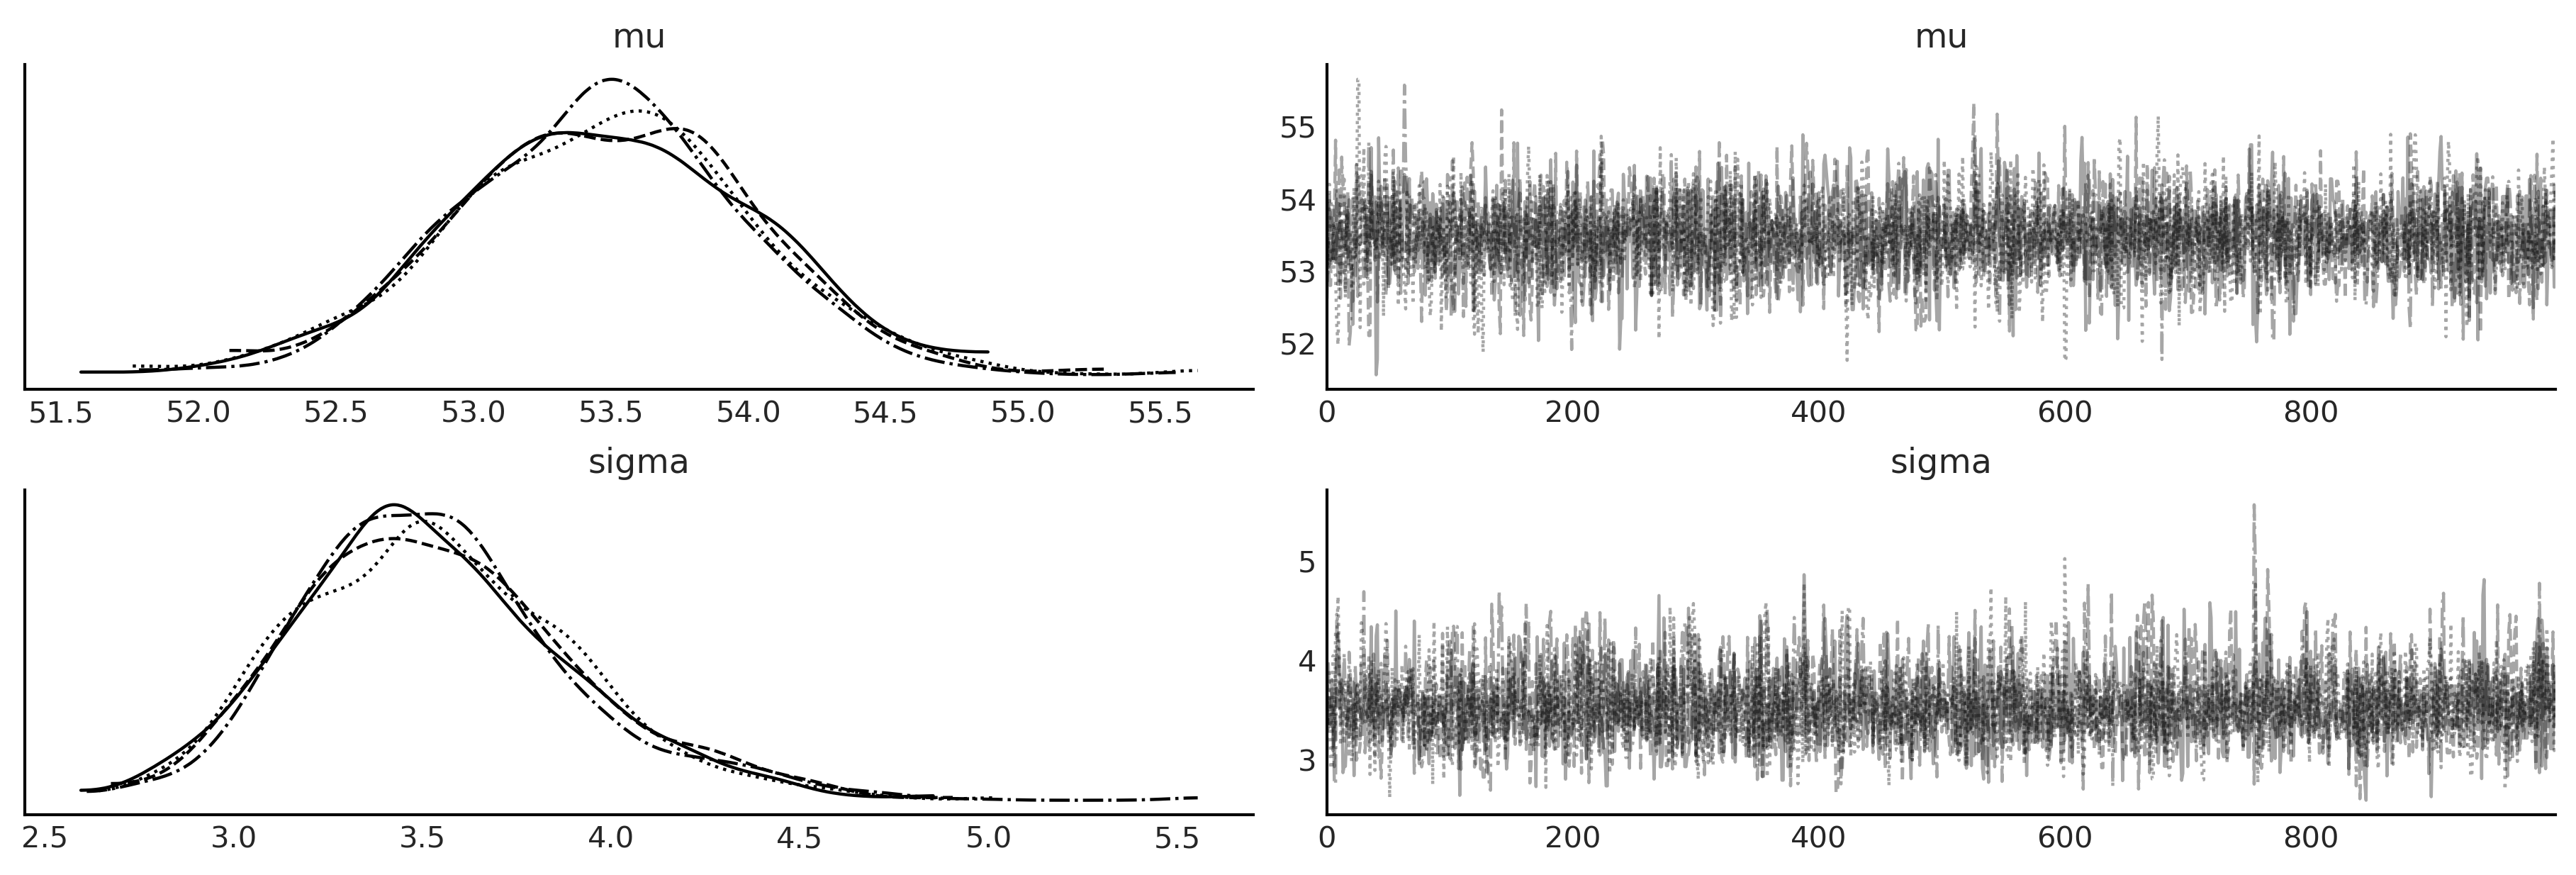

In [23]:
az.plot_trace(idata_g);

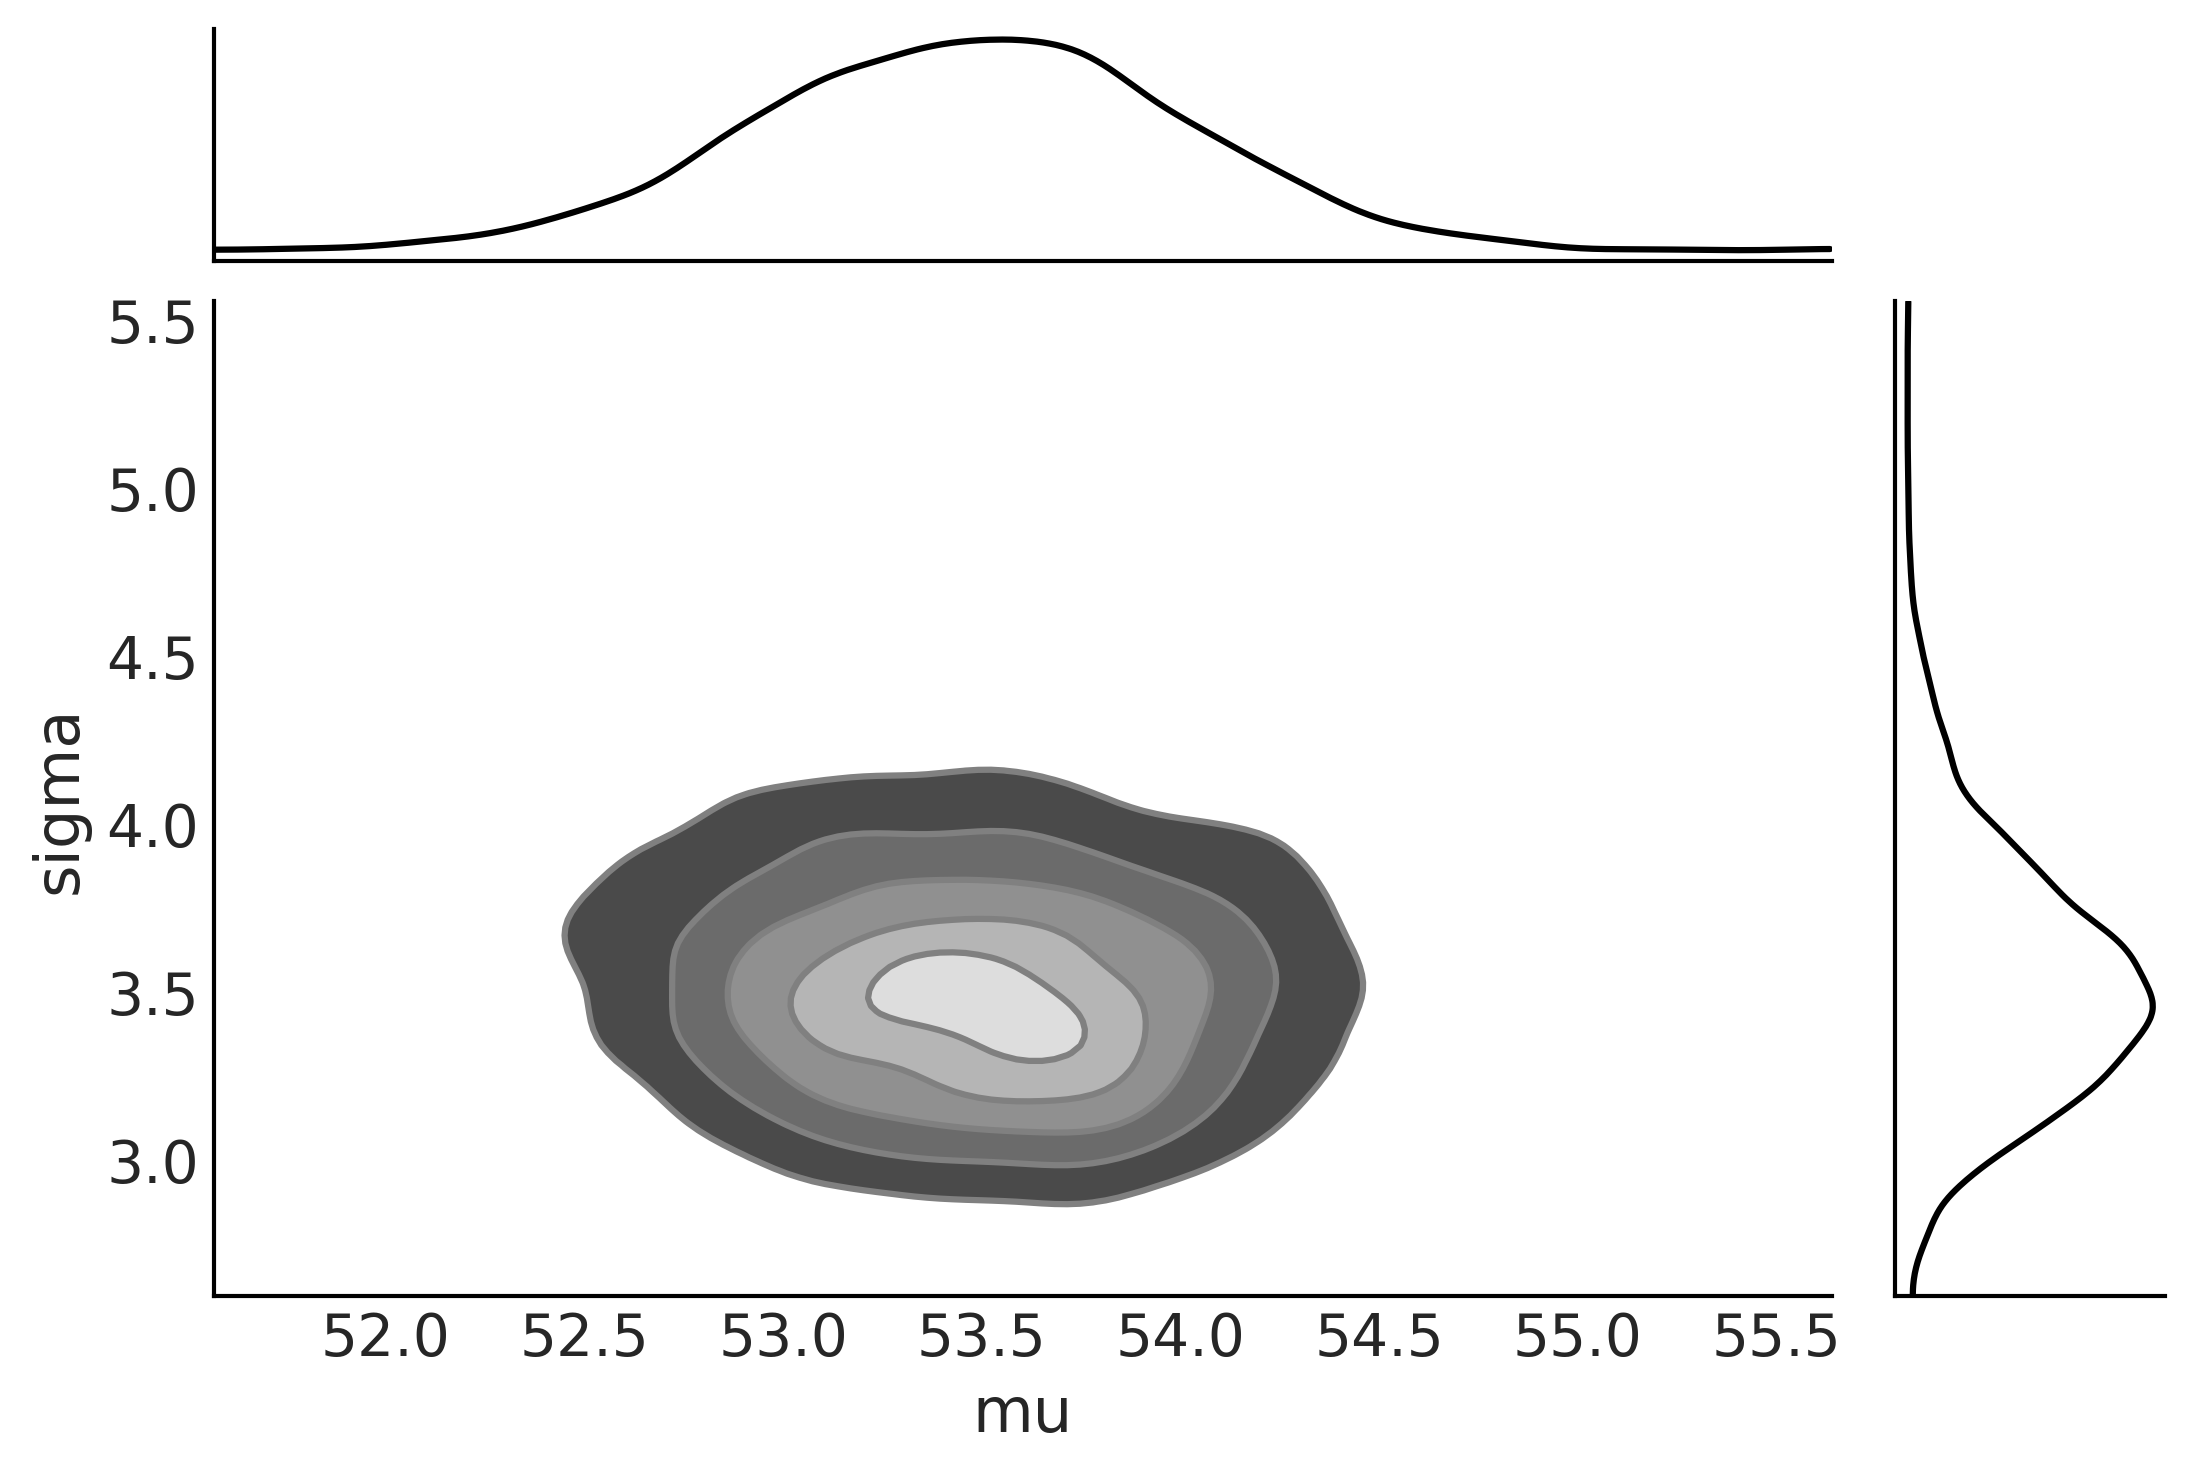

In [24]:
az.plot_pair(idata_g, kind = 'kde', marginals=True);

In [25]:
az.summary(idata_g, kind = 'stats').round(2)

mean    sd  hdi_3%  hdi_97%
mu     53.47  0.53   52.46    54.43
sigma   3.53  0.36    2.90     4.26

## Posterior Predictive Checks

In [26]:
pm.sample_posterior_predictive(idata_g, model=model_g, extend_inferencedata=True)

Sampling: [Y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

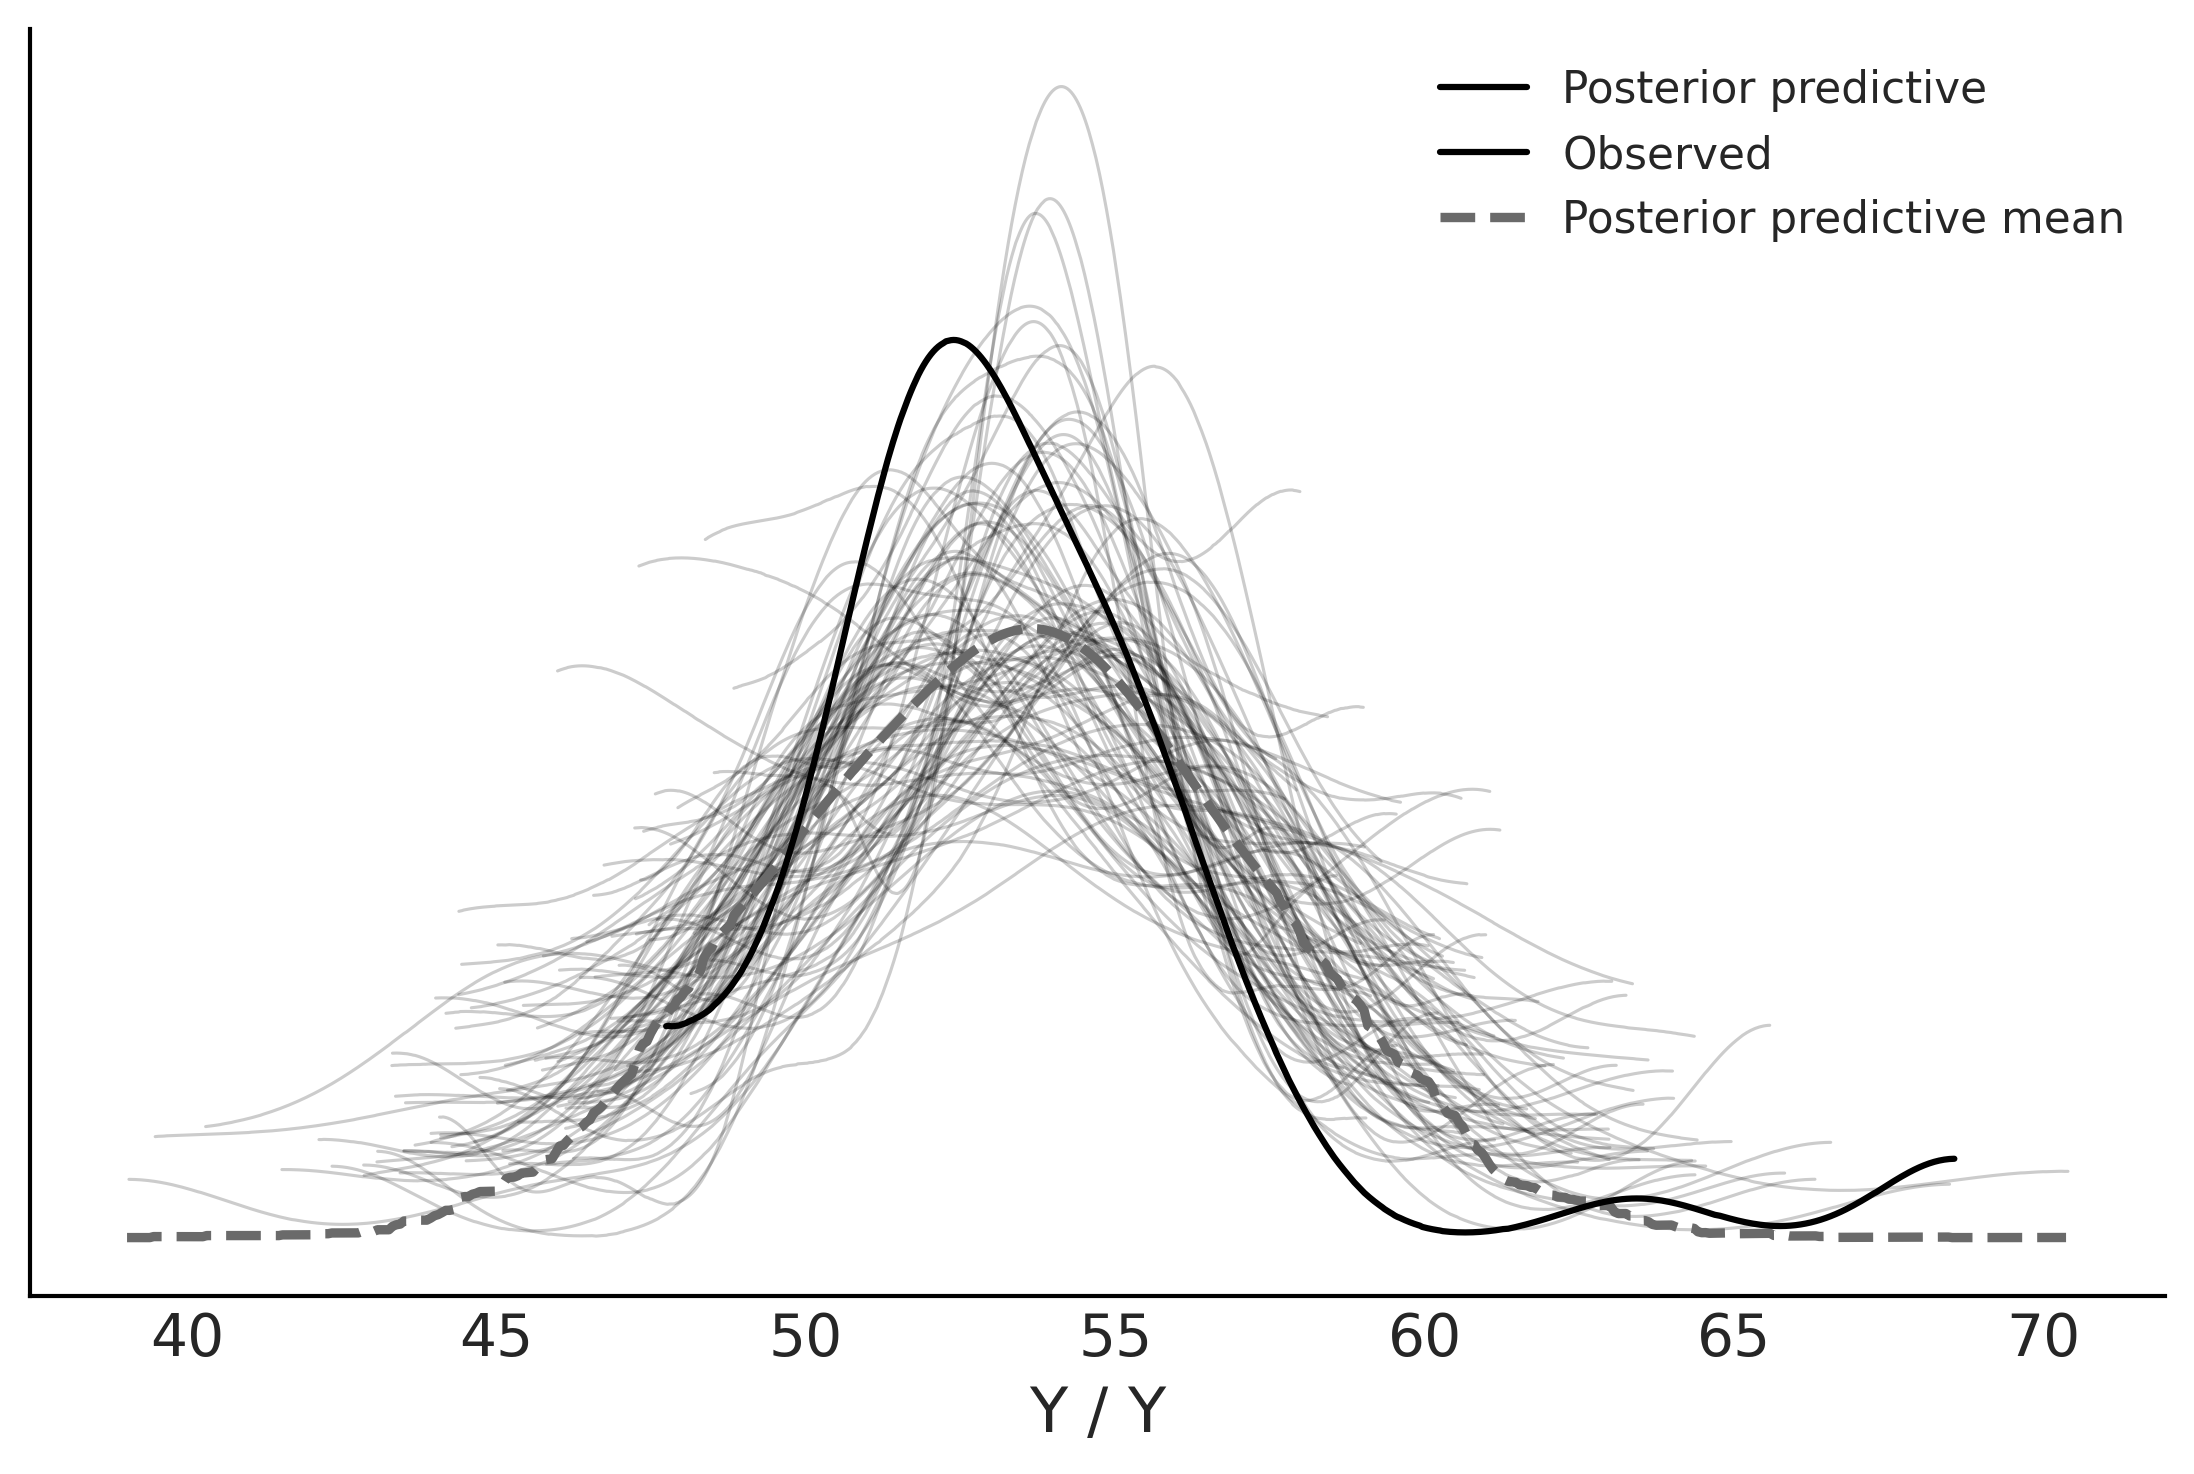

In [27]:
az.plot_ppc(idata_g, num_pp_samples=100);

The two outliers to the right are contributing to pulling the mean of the simulated data to the right and resulting in a variance that is larger than actual.  The choice of the prior is also a contributing factor.

Generic rules for removing outliers:
- Remove points that fall outside 1.5 times the IQR
- Remove points outside 2-3 standard deviations from the mean

# Robust Estimation
Rather than remove outliers we can use a StudentT distribution to fit a model that is less sensitive to outliers.
This allows for a more **robust estimate** of the mean &mu; and standard deviation &sigma;.  Outliers have the effect of reducing the value of &nu;

In [28]:
with pm.Model() as model_t:
    mu = pm.Uniform('mu', 40, 75)
    sigma = pm.HalfNormal('sigma', sigma=10)
    nu = pm.Exponential('nu', 1/30) # in PyMC the exponential is parameterised as 1/mean
    y = pm.StudentT('y', nu=nu, mu=mu, sigma=sigma, observed=data)
    idata_t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


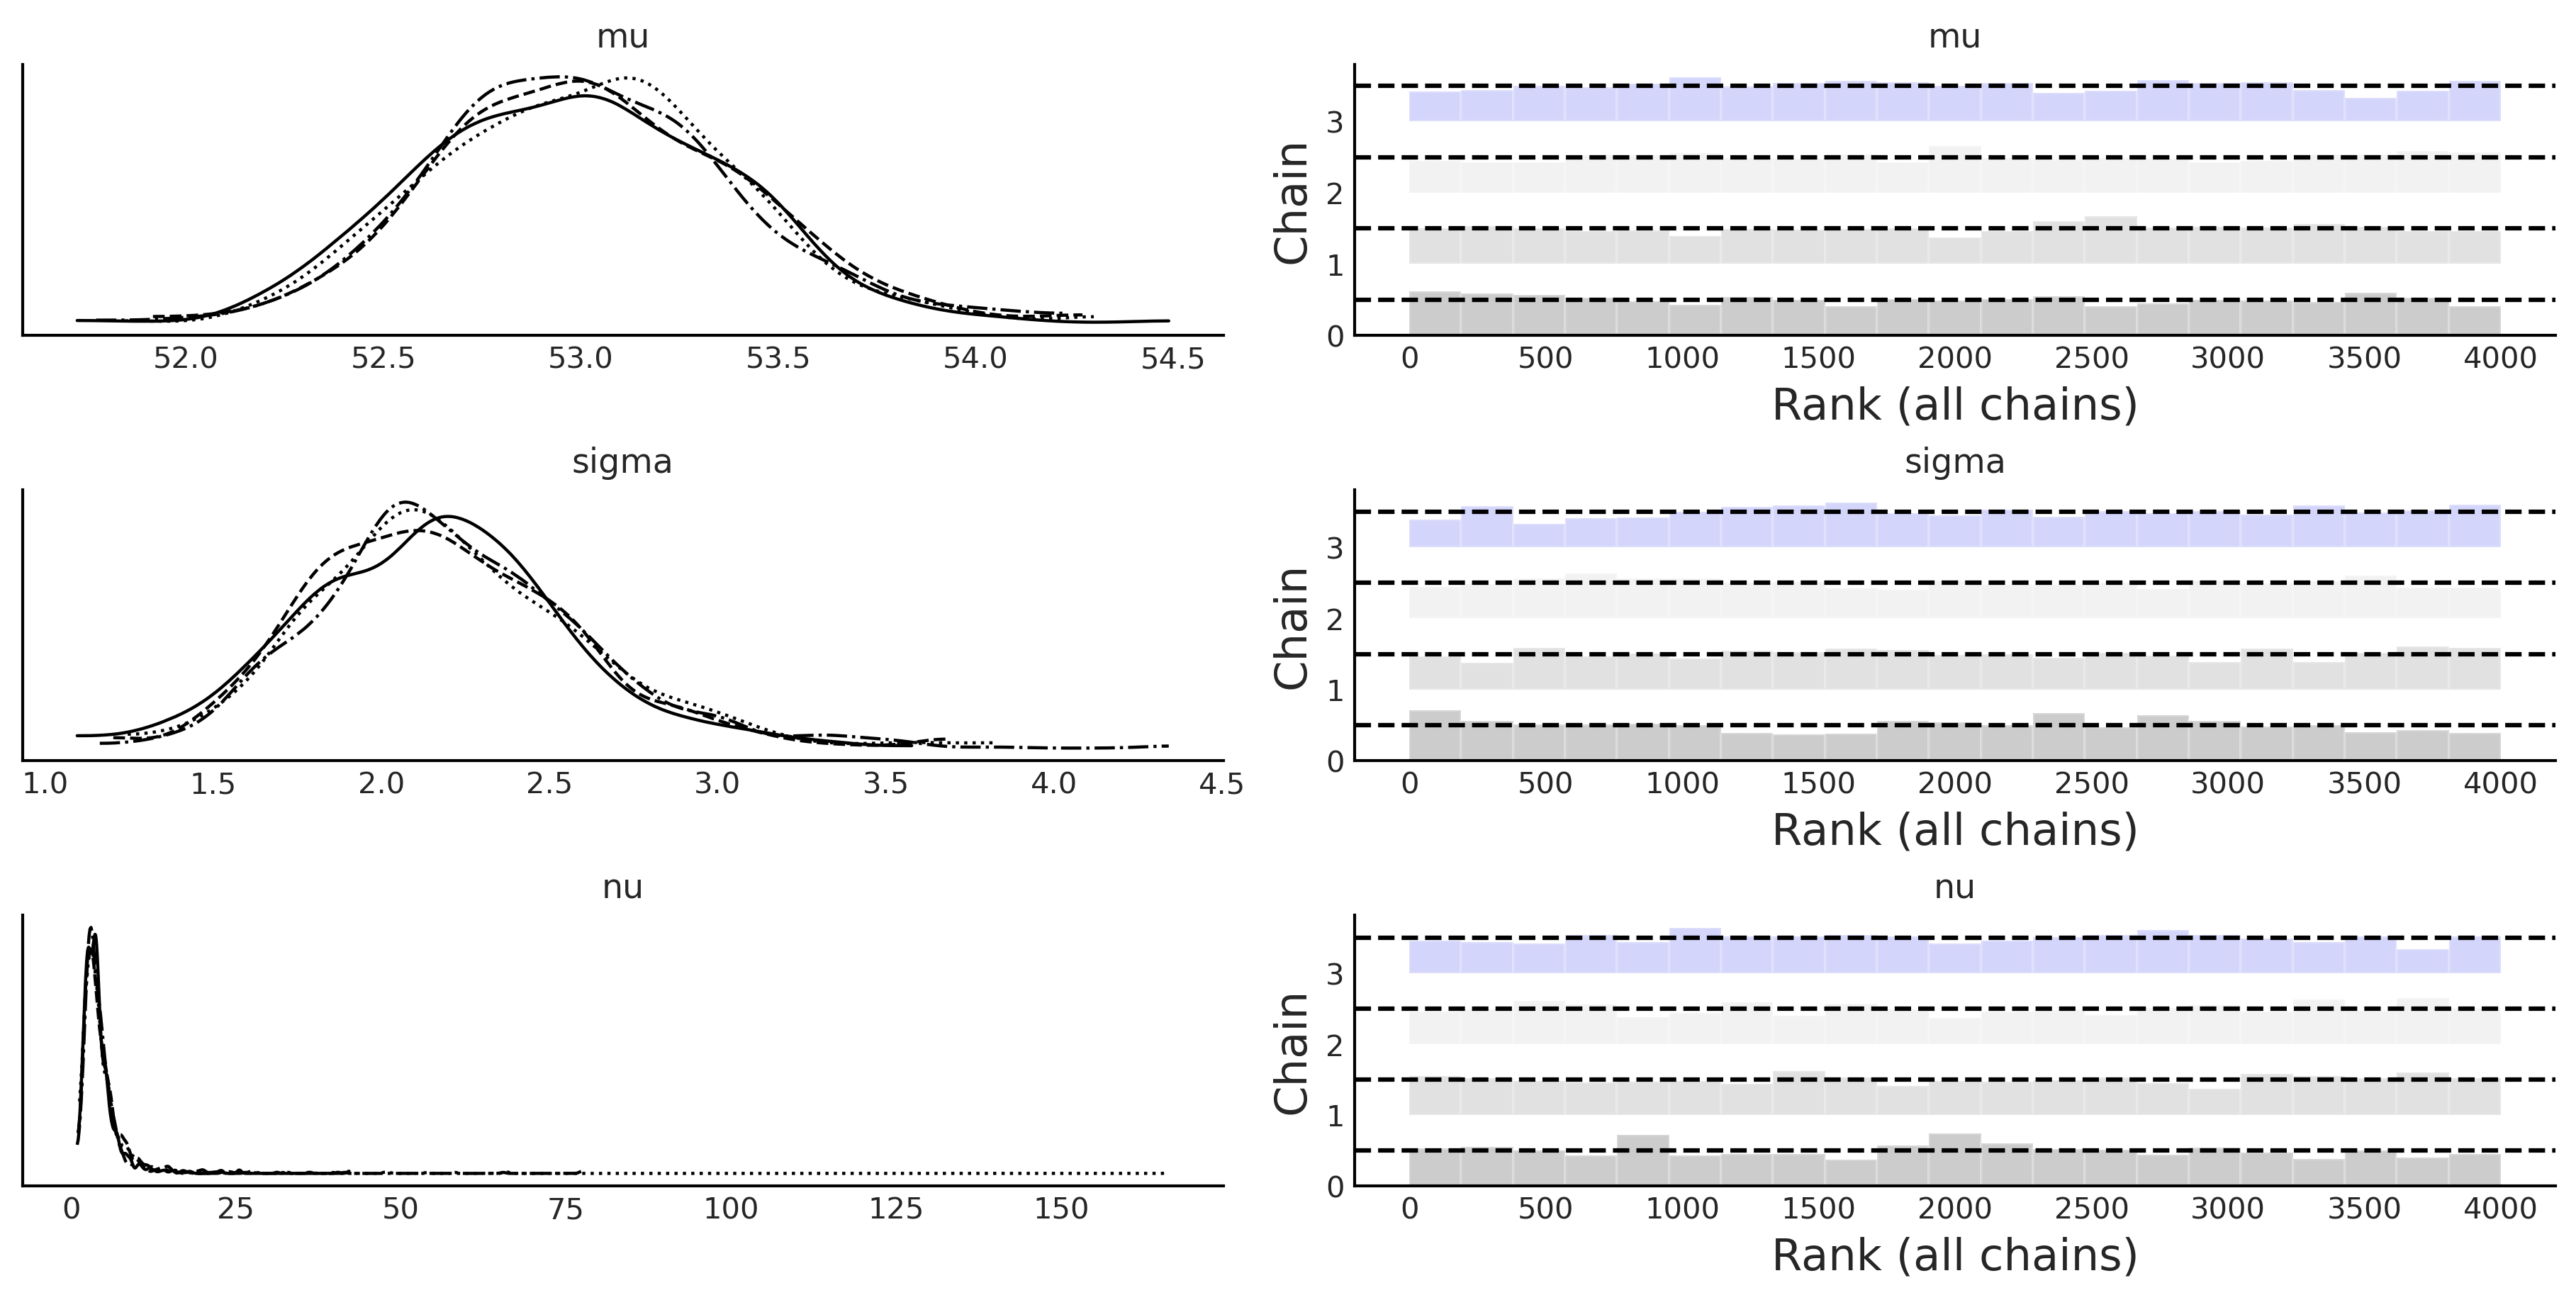

In [29]:
az.plot_trace(idata_t, kind='rank_bars');

In [30]:
az.summary(idata_t, kind = 'stats').round(2)

mean    sd  hdi_3%  hdi_97%
mu     53.01  0.37   52.33    53.70
sigma   2.19  0.40    1.49     2.96
nu      4.69  4.91    1.26     9.26

The lower the value of nu the higher the kurtosis

In [31]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True)

Sampling: [y]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Sampling: [y]


(40.0, 70.0)

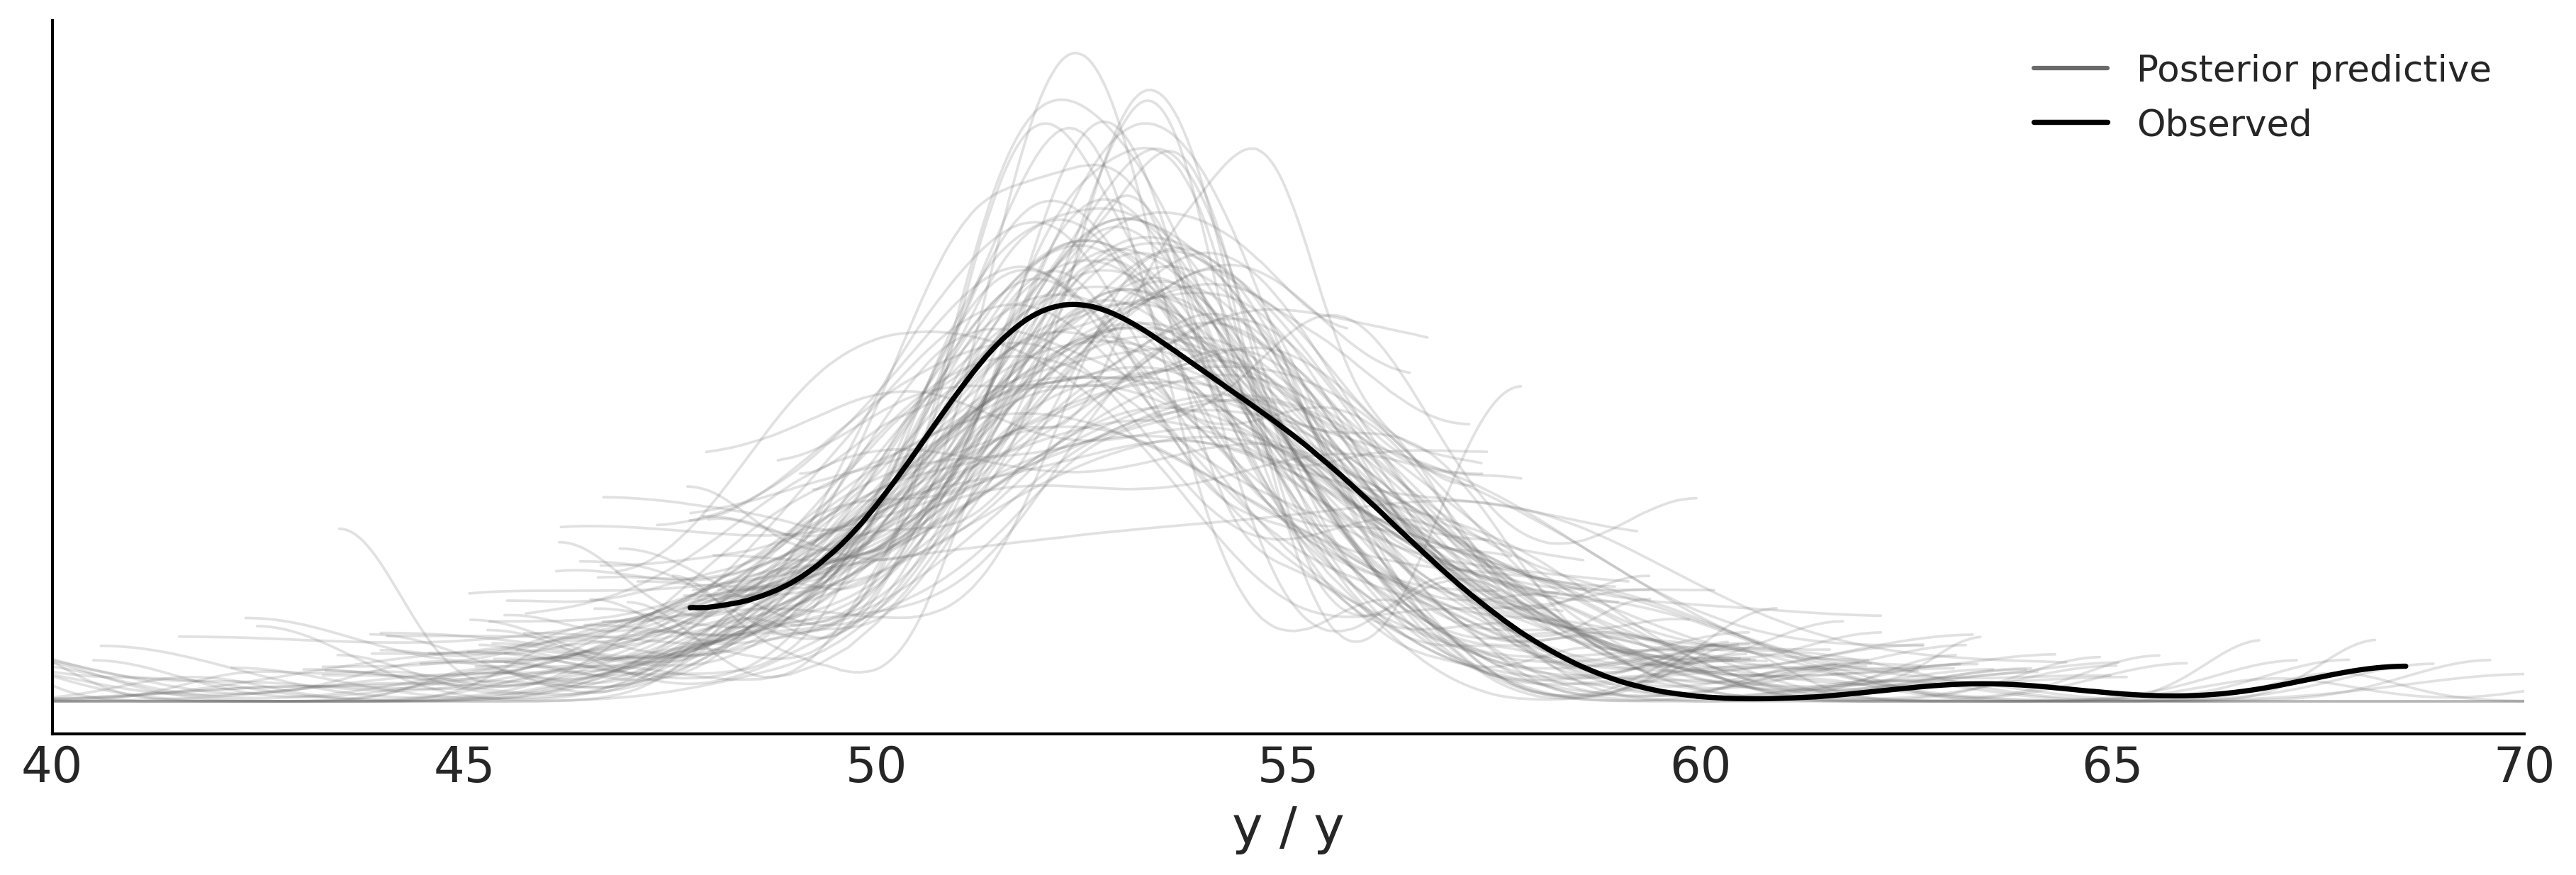

In [32]:
pm.sample_posterior_predictive(idata_t, model=model_t, extend_inferencedata=True, random_seed=123)
ax= az.plot_ppc(idata_t, figsize=(12, 4), num_pp_samples=100, mean=False, colors=["C1", "C0", "C1"])
ax.set_xlim(40, 70)

# InferenceData
Accessing the posterior group returns an xarray dataset
https://docs.xarray.dev/en/stable

"xarray, imagine NumPy multidimensional arrays but with labels!"

In [33]:
posterior = idata_g.posterior

In [34]:
# The following code returns the first draw from chain 0 and chain 2
posterior.sel(draw=0, chain=[0,2])

<xarray.Dataset>
Dimensions:  (chain: 2)
Coordinates:
  * chain    (chain) int64 0 2
    draw     int64 0
Data variables:
    mu       (chain) float64 53.92 52.62
    sigma    (chain) float64 3.356 3.317
Attributes:
    created_at:                 2024-02-24T19:49:00.788415
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.458613395690918
    tuning_steps:               1000

In [35]:
# Use the sel method to select a range of values, like the first 100 draws from all chains
posterior.sel(draw=slice(0, 100))

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 101)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
Data variables:
    mu       (chain, draw) float64 53.92 53.92 53.08 53.28 ... 54.33 54.28 54.28
    sigma    (chain, draw) float64 3.356 3.356 3.407 3.352 ... 3.976 4.095 4.189
Attributes:
    created_at:                 2024-02-24T19:49:00.788415
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.458613395690918
    tuning_steps:               1000

The following returns the mean for &mu; and &sigma; computed over all draws and chains:

In [36]:
posterior.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 53.47
    sigma    float64 3.534

In [37]:
# dir(posterior.mean())
res = posterior.mean()
res.to_dataframe

<bound method Dataset.to_dataframe of <xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 53.47
    sigma    float64 3.534>

Return the mean and sigma for each of the 4 chains

In [38]:
posterior.mean("draw").to_pandas

<bound method Dataset.to_pandas of <xarray.Dataset>
Dimensions:  (chain: 4)
Coordinates:
  * chain    (chain) int64 0 1 2 3
Data variables:
    mu       (chain) float64 53.47 53.47 53.49 53.45
    sigma    (chain) float64 3.521 3.533 3.545 3.536>

To get the posterior samples use az.extract().  This combines the chain and draw into a sample coordinate.  By defualt it operates onthe posterior but you can specify other groups with the group arguement.

In [39]:
stacked = az.extract(idata_g)
stacked

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    mu       (sample) float64 53.92 53.92 53.08 53.28 ... 53.09 54.18 53.93
    sigma    (sample) float64 3.356 3.356 3.407 3.352 ... 3.536 3.953 3.41 3.469
Attributes:
    created_at:                 2024-02-24T19:49:00.788415
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.458613395690918
    tuning_steps:               1000

Get a random sample of the posterior

In [40]:
az.extract(idata_g, num_samples=100)

<xarray.Dataset>
Dimensions:  (sample: 100)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 1 1 2 3 0 2 3 2 3 1 1 0 ... 0 3 1 1 1 0 3 2 2 1 1 0
  * draw     (sample) int64 96 937 143 653 341 187 996 ... 104 964 236 6 542 213
Data variables:
    mu       (sample) float64 52.98 52.9 53.75 53.11 ... 53.38 52.97 53.81 53.53
    sigma    (sample) float64 3.466 4.084 3.918 3.589 ... 3.308 3.768 4.009
Attributes:
    created_at:                 2024-02-24T19:49:00.788415
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.8.0
    sampling_time:              1.458613395690918
    tuning_steps:               1000

# Groups comparison

## Measuring effect size

In [41]:
# Measure the effect of day of the week on tips earned
tips = pd.read_csv("../code/data/tips.csv")
tips.tail()

total_bill   tip     sex smoker   day    time  size
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

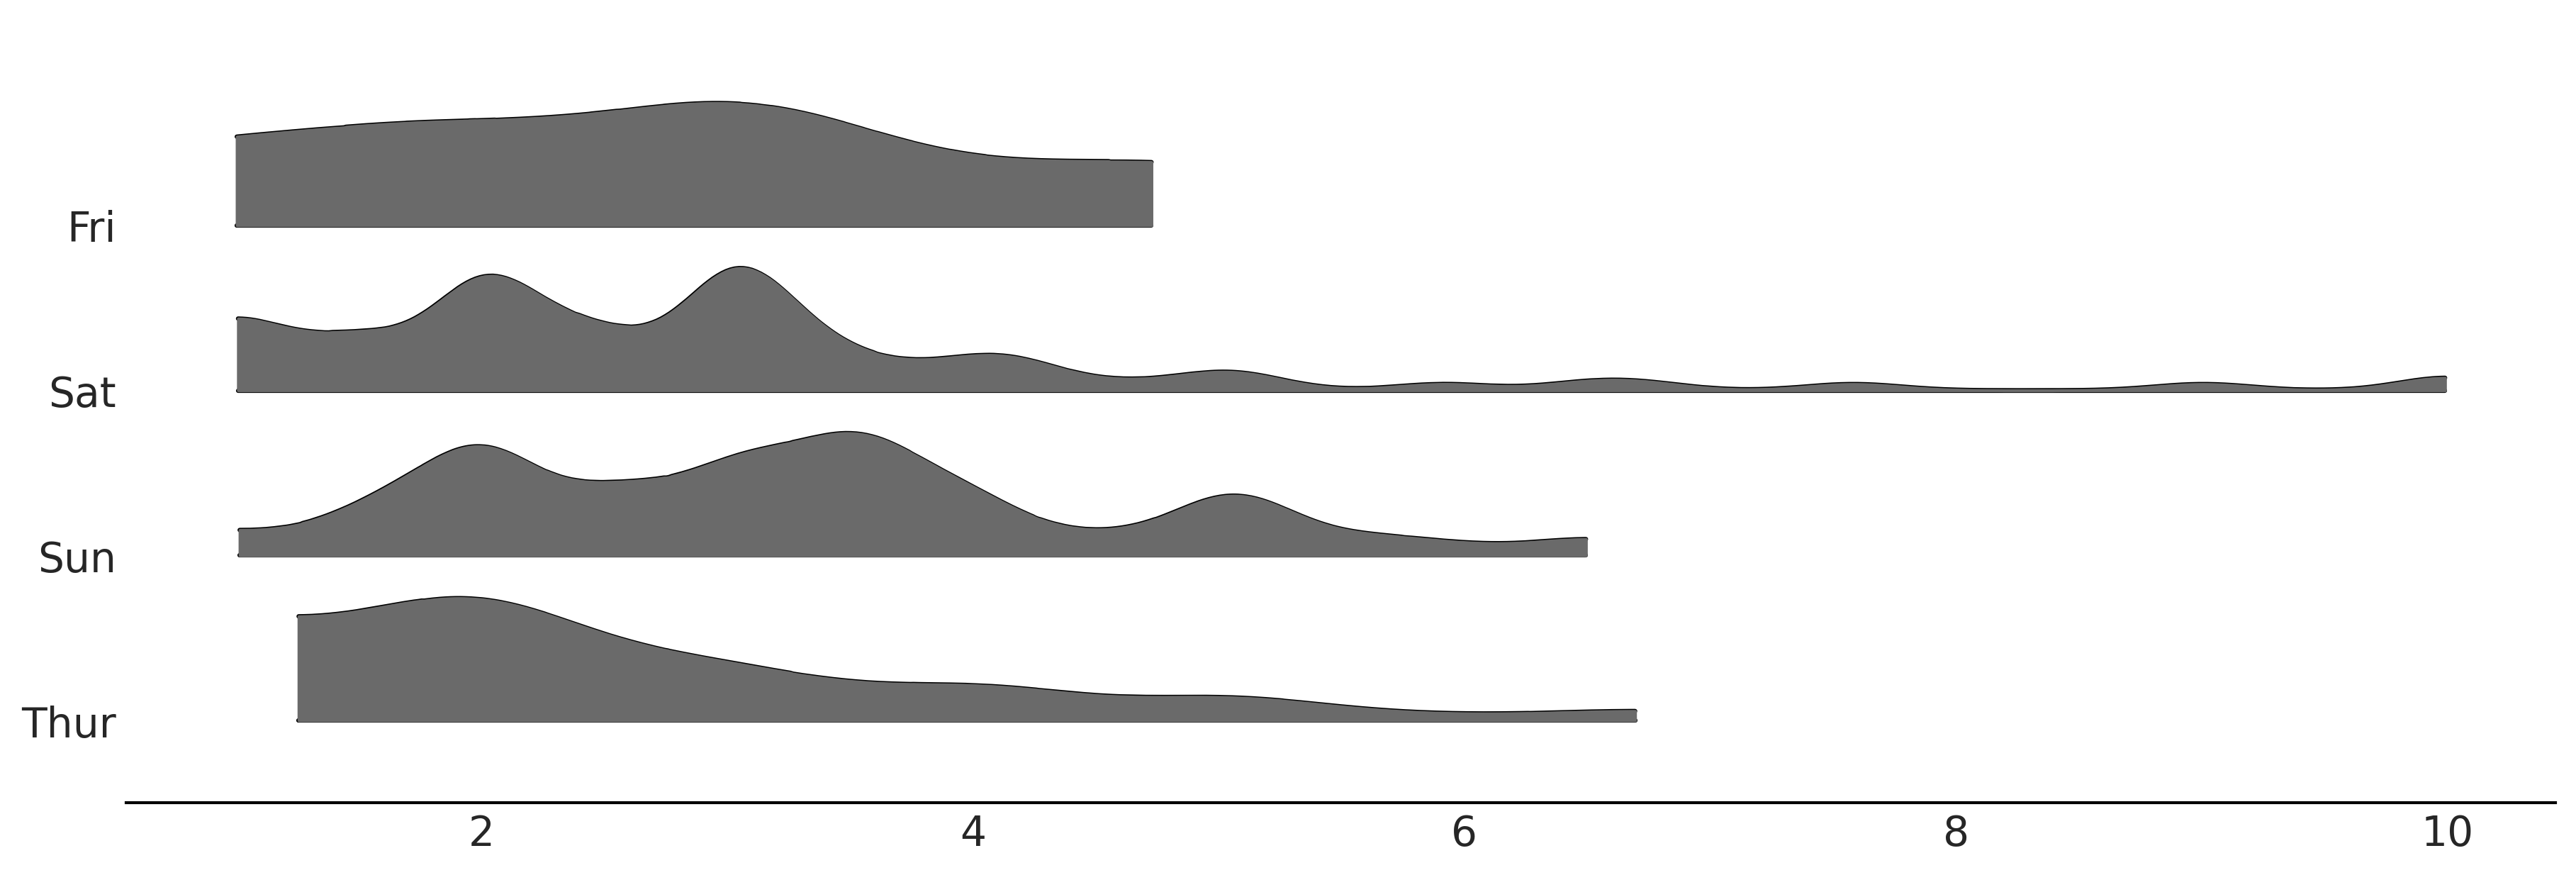

In [42]:
az.plot_forest(tips.pivot(columns="day", values="tip").to_dict("list"),
               kind="ridgeplot", 
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4));

In [43]:
categories = np.array(["Thur", "Fri", "Sat", "Sun"])
tip = tips["tip"].values
idx = pd.Categorical(tips["day"], categories=categories).codes

In [44]:
with pm.Model() as comparing_groups:
    mu = pm.Normal("mu", mu=0, sigma=10, shape=4)
    sigma = pm.HalfNormal("sigma", sigma=10, shape = 4)
    # We are specifying four independent normal and halfnormal distributions using an index syntax
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=tip)

In [45]:
coords = {"days": categories, "days_flat":categories[idx]}

with pm.Model (coords=coords) as comparing_groups:
    mu = pm.HalfNormal("mu", sigma=5, dims="days")
    sigma = pm.HalfNormal("sigma", sigma=1, dims="days")

    y = pm.Gamma("y", mu=mu[idx], sigma=sigma[idx], observed=tip, dims="days_flat")

    idata_cg = pm.sample()
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


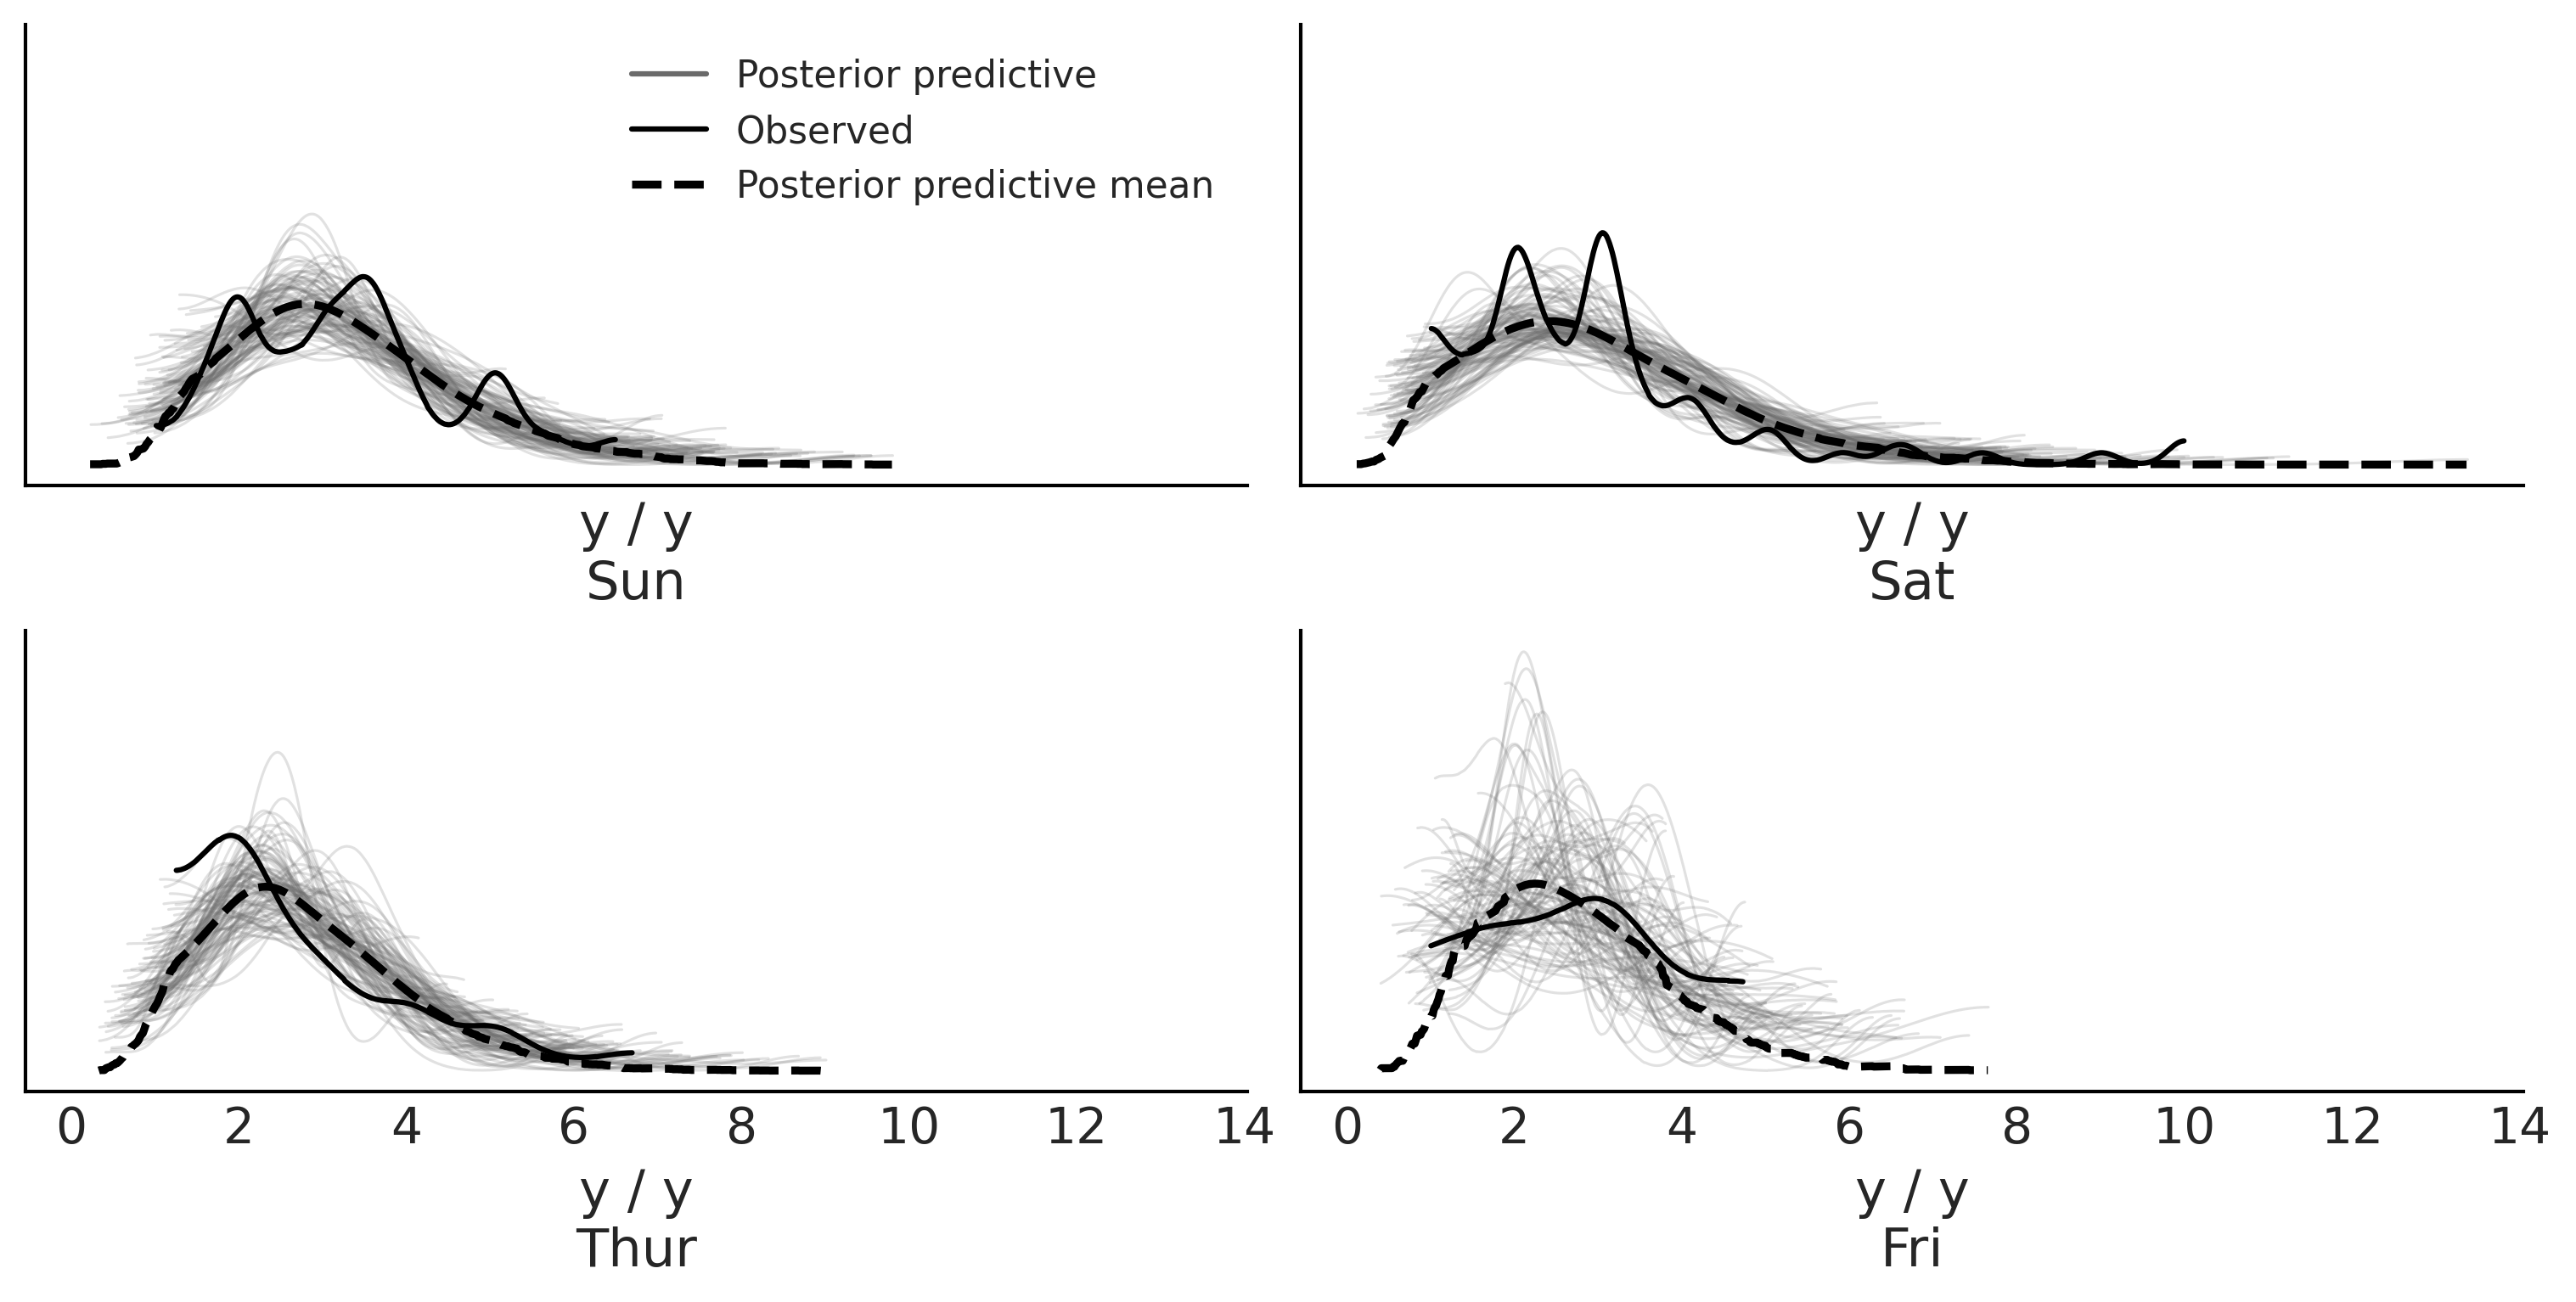

In [46]:
_, axes = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
az.plot_ppc(idata_cg, num_pp_samples=100,
            colors=["C1", "C0", "C0"],
           coords={"days_flat":[categories]}, flatten = [], ax=axes);

## Cohen's d and Probability of Superiority
http://rpsychologist.com/d3/cohend

In [ ]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

In [50]:
comparisons

[('Thur', 'Fri'),
 ('Thur', 'Sat'),
 ('Thur', 'Sun'),
 ('Fri', 'Sat'),
 ('Fri', 'Sun'),
 ('Sat', 'Sun')]

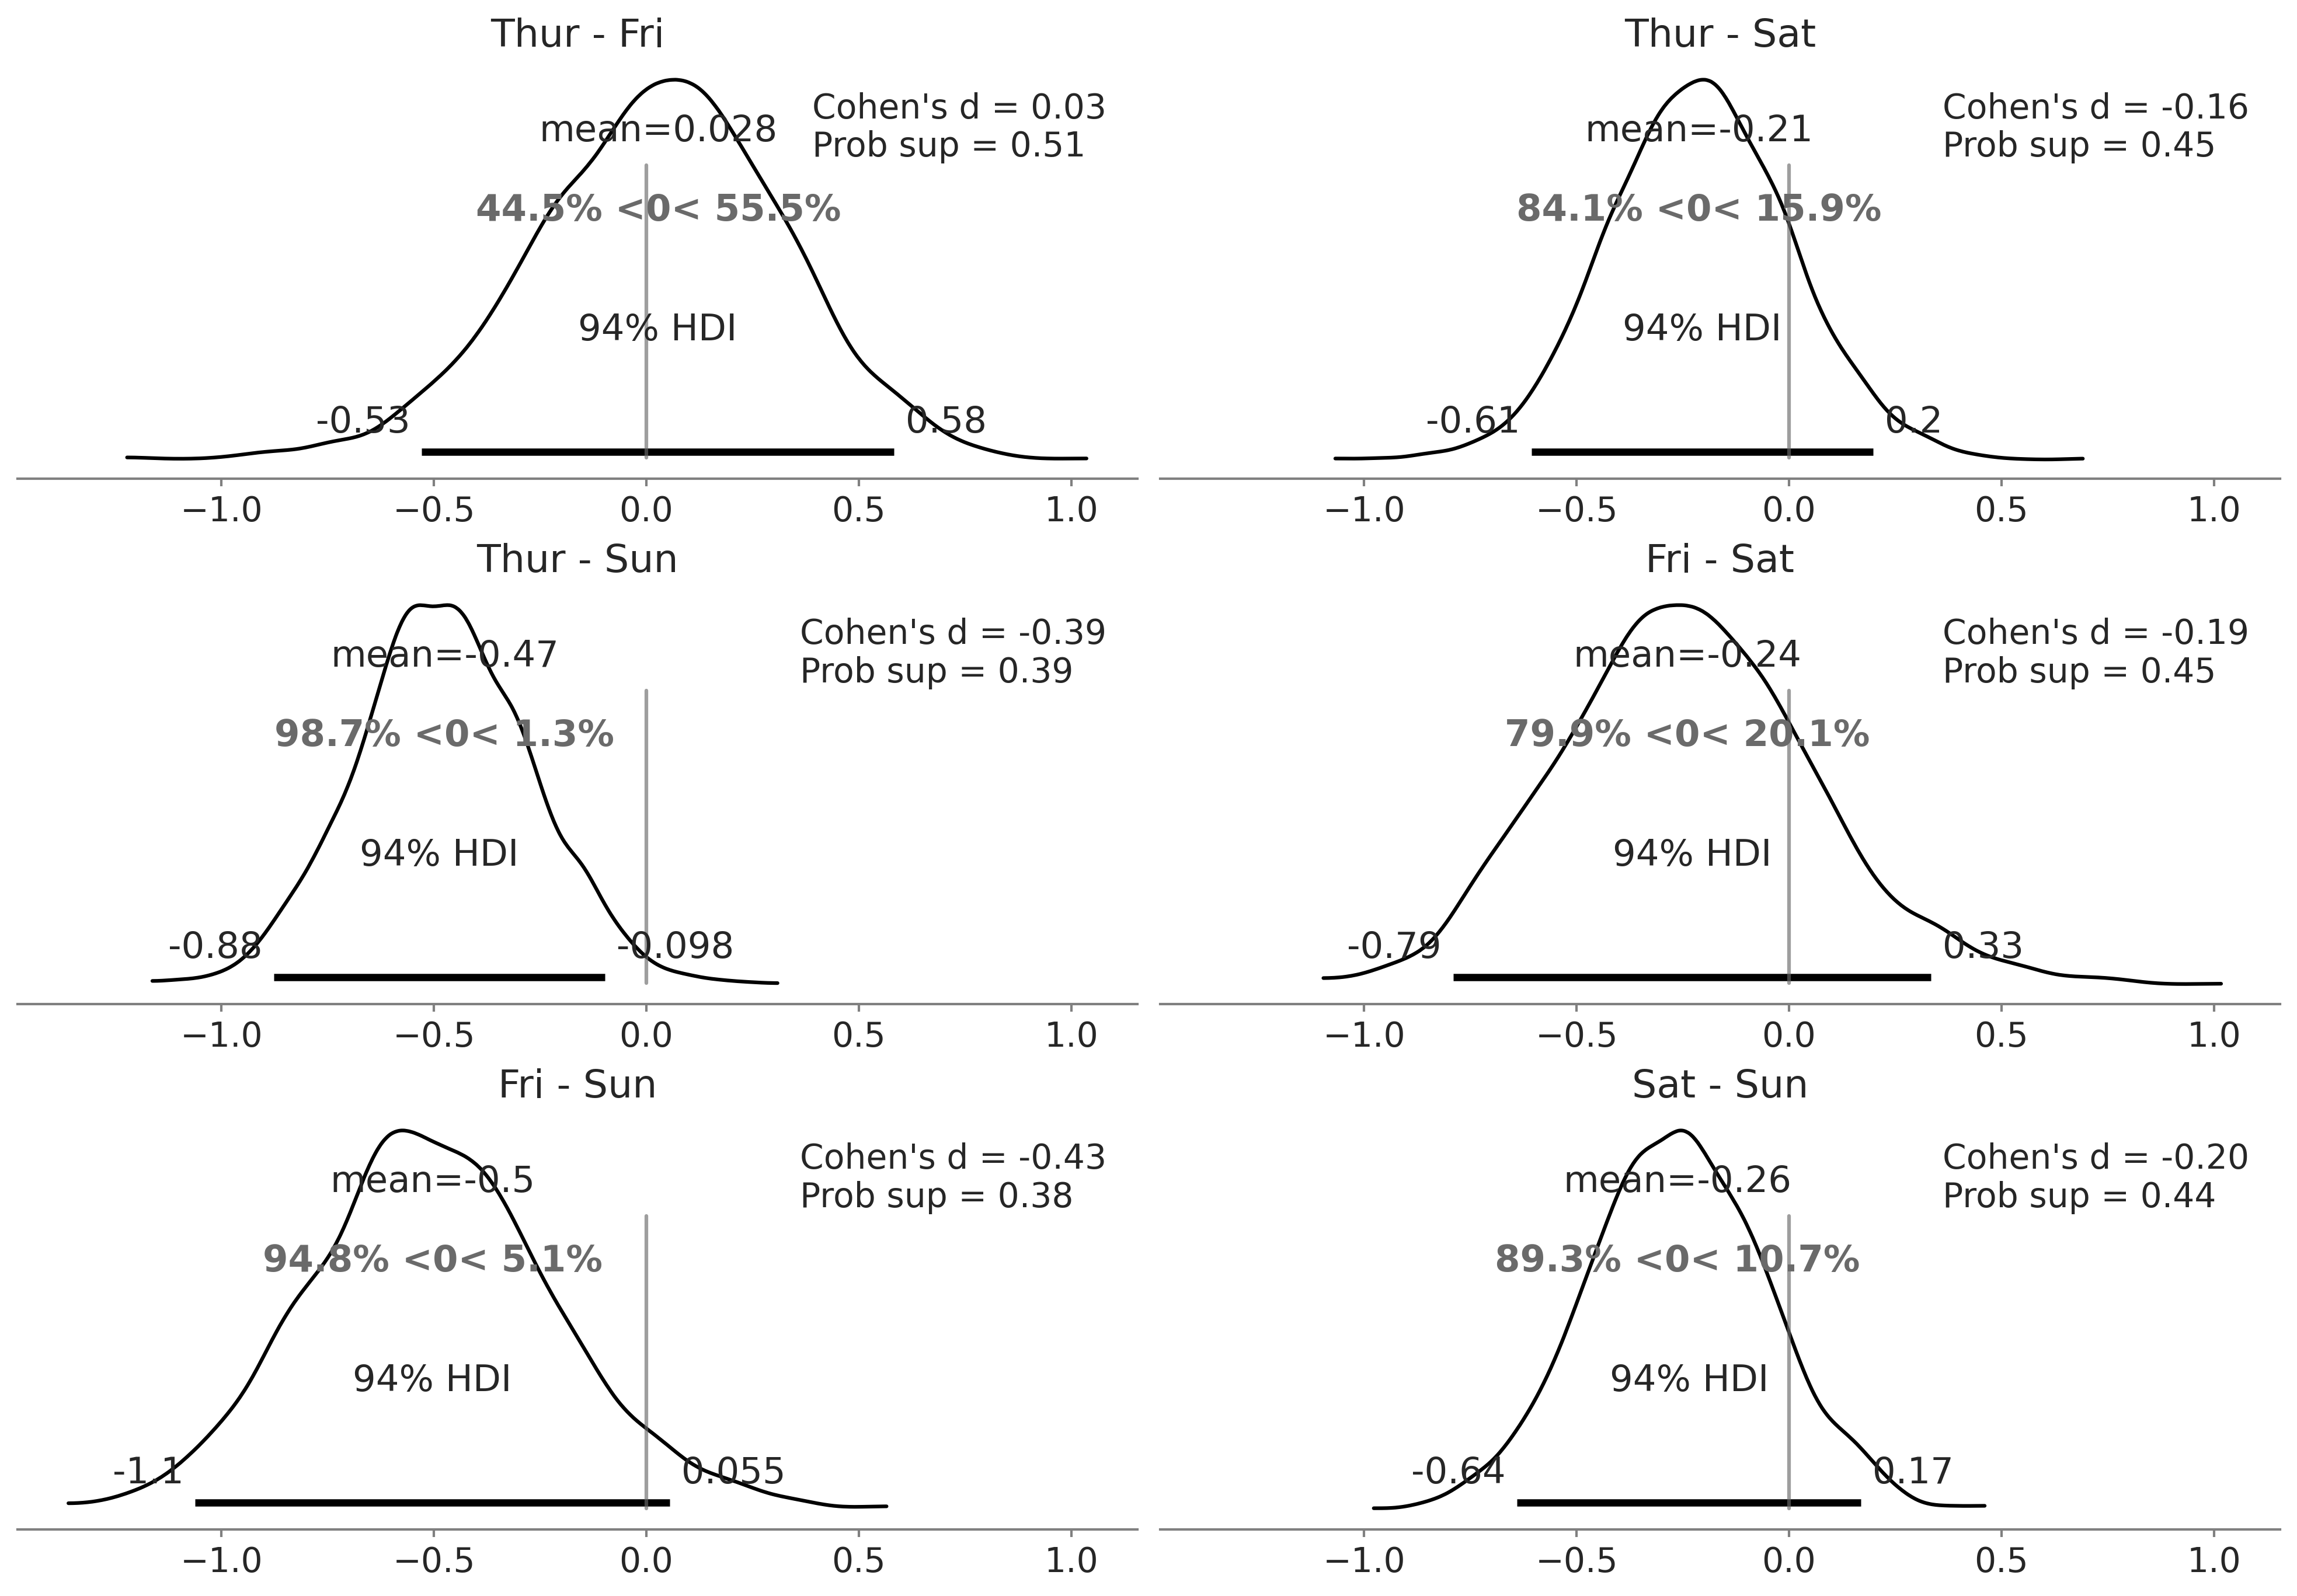

In [51]:
_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["mu"].sel(days=i) - cg_posterior['mu'].sel(days=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["sigma"].sel(days=i)**2 + 
                        cg_posterior["sigma"].sel(days=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)